<a href="https://colab.research.google.com/github/caninehawk/Sleep-Stage-Prediction-using-TimeGAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/Assignment/sleep_cycle/combined.zip /content/.
!du -sh /content/combined.zip
!unzip /content/combined.zip
!rm -rf /content/combined.zip /content/sample_data

Mounted at /content/drive
2.6M	/content/combined.zip
Archive:  /content/combined.zip
   creating: combined/
  inflating: combined/combined-sleep-2711.csv  
  inflating: combined/combined-sleep-2938.csv  
  inflating: combined/combined-sleep-3538.csv  
  inflating: combined/combined-sleep-3913.csv  
  inflating: combined/combined-sleep-4506.csv  
  inflating: combined/combined-sleep-4728.csv  
  inflating: combined/combined-sleep-6337.csv  
  inflating: combined/combined-sleep-6567.csv  
  inflating: combined/combined-sleep-6796.csv  


In [ ]:
!pip install scikit-plot scipy==1.11.4
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", 

For Keras models, training them will automatically leverage the GPU if detected. For instance, when you call `model.fit()`, TensorFlow will use the GPU for the computations if available.

**Important Considerations:**

*   **Model Complexity:** Simple models or operations might not show a significant speedup on the GPU due to the overhead of transferring data between the CPU and GPU. More complex models and larger datasets benefit most from GPU acceleration.
*   **Data Loading:** Ensure your data loading pipeline is efficient. Bottlenecks in data loading can limit GPU utilization. Using `tf.data` can help with this.
*   **Batch Size:** Larger batch sizes can sometimes improve GPU utilization, but be mindful of GPU memory limits.
*   **TensorFlow Version:** Ensure you are using a TensorFlow version that supports the GPU and your CUDA/cuDNN setup (Colab usually handles this for you).

By following these steps and ensuring your deep learning code is structured appropriately, you should be able to effectively utilize the T4 GPU in your Colab environment.

If the output above shows a GPU (like a T4), TensorFlow is configured to use it. By default, TensorFlow will try to place operations on the GPU if one is available.

To explicitly place operations or a model on the GPU, you can use `tf.device('/GPU:0')` (or the appropriate GPU index if you have multiple). However, for Keras models, they are typically placed on the available GPU automatically.

Here's an example demonstrating a simple operation on the GPU:

In [5]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("TensorFlow detected the following GPU(s):")
    for gpu in gpu_available:
        print(f"  Name: {gpu.name}, Type: {gpu.device_type}")
else:
    print("TensorFlow did not detect any GPU.")

TensorFlow detected the following GPU(s):
  Name: /physical_device:GPU:0, Type: GPU


First, let's check if TensorFlow can detect the GPU:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

final_df = pd.DataFrame()
for data_path in os.listdir('/content/combined'):
    df = pd.read_csv(os.path.join('/content/combined',data_path))
    final_df = pd.concat([final_df, df])

final_df.head()
df = final_df.copy()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import time

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample # For BiLSTM oversampling

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE # Ensure 'imbalanced-learn' is installed for SMOTE

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(42) # For reproducibility across all splits and models

# --- CONFIGURATION ---
# IMPORTANT: Adjust this path to where your 'combined' folder with CSVs is located.
# Based on your previous output, it's likely '/content/combined' in Colab.
data_dir = '/content/combined'

In [8]:
SEQ_LENGTH = 30
TEST_SIZE = 0.2
RANDOM_SEED = 42
EPOCHS = 100 # Reduced epochs for faster execution during comparison, can be increased for final training
BATCH_SIZE = 64

# Additional imports for TGAN/CTGAN
try:
    from sdv.single_table import CTGANSynthesizer
    from sdv.metadata import SingleTableMetadata
    SDV_AVAILABLE = True
    print("SDV library found. Using CTGAN for synthetic data generation.")
except ImportError:
    SDV_AVAILABLE = False
    print("SDV library not found. Using custom TimeGAN implementation.")

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# Custom TimeGAN implementation for time series synthetic data generation
class TimeGAN:
    def __init__(self, seq_len, n_seq, hidden_dim=24, gamma=1, noise_dim=32, dim=128, batch_size=128, learning_rate=5e-4):
        self.seq_len = seq_len
        self.n_seq = n_seq
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.noise_dim = noise_dim
        self.dim = dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        # Build networks
        self.build_networks()

    def build_networks(self):
        # Embedder network
        self.embedder = self.build_embedder()
        # Recovery network
        self.recovery = self.build_recovery()
        # Generator network
        self.generator = self.build_generator()
        # Discriminator network
        self.discriminator = self.build_discriminator()
        # Supervisor network
        self.supervisor = self.build_supervisor()

    def build_embedder(self):
        inputs = Input(shape=(self.seq_len, self.n_seq))
        h = LSTM(self.hidden_dim, return_sequences=True)(inputs)
        h = LSTM(self.hidden_dim, return_sequences=True)(h)
        outputs = Dense(self.hidden_dim, activation='sigmoid')(h)
        return Model(inputs=inputs, outputs=outputs, name='embedder')

    def build_recovery(self):
        inputs = Input(shape=(self.seq_len, self.hidden_dim))
        h = LSTM(self.hidden_dim, return_sequences=True)(inputs)
        h = LSTM(self.hidden_dim, return_sequences=True)(h)
        outputs = Dense(self.n_seq, activation='sigmoid')(h)
        return Model(inputs=inputs, outputs=outputs, name='recovery')

    def build_generator(self):
        inputs = Input(shape=(self.seq_len, self.noise_dim))
        h = LSTM(self.hidden_dim, return_sequences=True)(inputs)
        h = LSTM(self.hidden_dim, return_sequences=True)(h)
        outputs = Dense(self.hidden_dim, activation='sigmoid')(h)
        return Model(inputs=inputs, outputs=outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape=(self.seq_len, self.hidden_dim))
        h = LSTM(self.hidden_dim, return_sequences=True)(inputs)
        h = LSTM(self.hidden_dim, return_sequences=False)(h)
        outputs = Dense(1, activation='sigmoid')(h)
        return Model(inputs=inputs, outputs=outputs, name='discriminator')

    def build_supervisor(self):
        inputs = Input(shape=(self.seq_len-1, self.hidden_dim))
        h = LSTM(self.hidden_dim, return_sequences=True)(inputs)
        outputs = Dense(self.hidden_dim, activation='sigmoid')(h)
        return Model(inputs=inputs, outputs=outputs, name='supervisor')

    def fit(self, X, epochs=1000):
        # Normalize data
        self.scaler_mean = np.mean(X, axis=(0, 1))
        self.scaler_std = np.std(X, axis=(0, 1)) + 1e-8
        X_scaled = (X - self.scaler_mean) / self.scaler_std

        # Compile models
        self.embedder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        self.recovery.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        self.generator.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy')
        self.discriminator.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy')
        self.supervisor.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

        # Training loop (simplified)
        print("Training TimeGAN...")
        for epoch in range(epochs):
            # Sample batch
            idx = np.random.randint(0, len(X_scaled), self.batch_size)
            real_data = X_scaled[idx]

            # Train embedder and recovery
            H = self.embedder.predict(real_data, verbose=0)
            X_tilde = self.recovery.predict(H, verbose=0)

            # Train generator and discriminator
            Z = np.random.uniform(0, 1, (self.batch_size, self.seq_len, self.noise_dim))
            E_hat = self.generator.predict(Z, verbose=0)
            H_hat = self.discriminator.predict(E_hat, verbose=0)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}")

    def generate(self, n_samples):
        """Generate synthetic time series data"""
        Z = np.random.uniform(0, 1, (n_samples, self.seq_len, self.noise_dim))
        E_hat = self.generator.predict(Z, verbose=0)
        X_hat = self.recovery.predict(E_hat, verbose=0)

        # Denormalize
        X_hat = X_hat * self.scaler_std + self.scaler_mean
        return X_hat

SDV library not found. Using custom TimeGAN implementation.


In [9]:
# Enhanced synthetic data generation function
def generate_synthetic_timeseries_data(X_sequences, y_sequences, target_samples_per_class=None, method='ctgan'):
    """
    Generate synthetic time series data using CTGAN or TimeGAN

    Parameters:
    - X_sequences: Input sequences (n_samples, seq_len, n_features)
    - y_sequences: Target labels (n_samples,)
    - target_samples_per_class: Target number of samples per class
    - method: 'ctgan' or 'timegan'
    """
    print(f"Generating synthetic data using {method.upper()}...")

    # Get class distribution
    unique_classes, class_counts = np.unique(y_sequences, return_counts=True)
    print(f"Original class distribution: {dict(zip(unique_classes, class_counts))}")

    if target_samples_per_class is None:
        target_samples_per_class = max(class_counts)

    X_synthetic_list = []
    y_synthetic_list = []

    for class_label in unique_classes:
        class_mask = y_sequences == class_label
        X_class = X_sequences[class_mask]
        current_count = len(X_class)

        if current_count >= target_samples_per_class:
            # If we have enough samples, just take what we need
            indices = np.random.choice(current_count, target_samples_per_class, replace=False)
            X_synthetic_list.append(X_class[indices])
            y_synthetic_list.append(np.full(target_samples_per_class, class_label))
            continue

        # Need to generate synthetic data
        samples_needed = target_samples_per_class - current_count

        if method == 'ctgan' and SDV_AVAILABLE:
            # Reshape sequences to tabular format for CTGAN
            n_samples, seq_len, n_features = X_class.shape

            # Flatten sequences and add time index and class label
            df_list = []
            for i, seq in enumerate(X_class):
                seq_df = pd.DataFrame(seq)
                seq_df['time_step'] = range(seq_len)
                seq_df['sample_id'] = i
                seq_df['class_label'] = class_label
                df_list.append(seq_df)

            if df_list:  # Check if we have data
                class_df = pd.concat(df_list, ignore_index=True)

                # Create metadata
                metadata = SingleTableMetadata()
                metadata.detect_from_dataframe(class_df)

                # Train CTGAN
                synthesizer = CTGANSynthesizer(metadata, epochs=100, verbose=False)
                synthesizer.fit(class_df)

                # Generate synthetic samples
                synthetic_samples_needed = samples_needed * seq_len
                synthetic_df = synthesizer.sample(num_rows=synthetic_samples_needed)

                # Convert back to sequence format
                synthetic_sequences = []
                for i in range(samples_needed):
                    start_idx = i * seq_len
                    end_idx = (i + 1) * seq_len
                    seq_data = synthetic_df.iloc[start_idx:end_idx, :n_features].values
                    if len(seq_data) == seq_len:
                        synthetic_sequences.append(seq_data)

                if synthetic_sequences:
                    synthetic_sequences = np.array(synthetic_sequences)
                    # Combine original and synthetic
                    X_combined = np.vstack([X_class, synthetic_sequences])
                else:
                    X_combined = X_class
            else:
                X_combined = X_class

        elif method == 'timegan':
            # Use custom TimeGAN implementation
            if len(X_class) > 1:  # Need at least 2 samples to train
                seq_len, n_features = X_class.shape[1], X_class.shape[2]

                # Initialize and train TimeGAN
                tgan = TimeGAN(seq_len=seq_len, n_seq=n_features, batch_size=min(32, len(X_class)))
                tgan.fit(X_class, epochs=200)

                # Generate synthetic samples
                synthetic_sequences = tgan.generate(samples_needed)

                # Combine original and synthetic
                X_combined = np.vstack([X_class, synthetic_sequences])
            else:
                X_combined = X_class

        else:
            # Fallback: simple oversampling with noise
            print(f"Using fallback oversampling with noise for class {class_label}")
            if current_count > 0:
                # Oversample by adding noise to existing samples
                indices = np.random.choice(current_count, samples_needed, replace=True)
                synthetic_samples = X_class[indices].copy()

                # Add small amount of noise
                noise_std = 0.01 * np.std(X_class, axis=(0, 1))
                noise = np.random.normal(0, noise_std, synthetic_samples.shape)
                synthetic_samples += noise

                X_combined = np.vstack([X_class, synthetic_samples])
            else:
                X_combined = X_class

        # Take exactly target_samples_per_class samples
        if len(X_combined) >= target_samples_per_class:
            indices = np.random.choice(len(X_combined), target_samples_per_class, replace=False)
            X_synthetic_list.append(X_combined[indices])
        else:
            X_synthetic_list.append(X_combined)

        y_synthetic_list.append(np.full(len(X_synthetic_list[-1]), class_label))

    # Combine all classes
    X_balanced = np.vstack(X_synthetic_list)
    y_balanced = np.concatenate(y_synthetic_list)

    # Shuffle the data
    shuffle_indices = np.random.permutation(len(X_balanced))
    X_balanced = X_balanced[shuffle_indices]
    y_balanced = y_balanced[shuffle_indices]

    print(f"Balanced class distribution: {dict(zip(*np.unique(y_balanced, return_counts=True)))}")

    return X_balanced, y_balanced

In [10]:
# --- 1. Data Loading and Initial Preprocessing (EXACTLY AS PER ORIGINAL NOTEBOOK) ---
print(f"Loading data from: {data_dir}")
final_df = pd.DataFrame()
try:
    for data_path in os.listdir(data_dir):
        # Skip non-CSV files and mesaid 4506 as per user's original notebook logic
        if not data_path.endswith('.csv') or '4506' in data_path:
            continue

        df_current_file = pd.read_csv(os.path.join(data_dir, data_path))
        df_current_file = df_current_file[df_current_file['interval'] != 'EXCLUDED']

        # Ensure unique_dayofweek contains at least two distinct days with sleep stage labels
        unique_dayofweek = df_current_file[~df_current_file['sleep stage'].isna()]['dayofweek'].unique()
        if len(unique_dayofweek) < 2:
            # print(f"Skipping {data_path}: Not enough labeled days for day/night split logic.")
            continue

        # Filter df_current_file to only include days that have sleep stage labels as per original logic
        df_filtered_days = df_current_file[df_current_file['dayofweek'].isin(unique_dayofweek)].copy()

        # --- Replicating original notebook's day/night split and feature creation ---
        # First day's data (dayofweek[0])
        df_prev_day_1 = df_filtered_days[df_filtered_days['dayofweek'] == unique_dayofweek[0]].copy()
        df_prev_day_1["linetime"] = pd.to_datetime(df_prev_day_1["linetime"], format="%H:%M:%S").dt.time # Original format
        morning_start = pd.to_datetime("09:00:00").time()
        night_end = pd.to_datetime("21:59:59").time()

        df_day = df_prev_day_1[(df_prev_day_1["linetime"] >= morning_start) & (df_prev_day_1["linetime"] <= night_end)]
        mid_df = df_prev_day_1[df_prev_day_1["linetime"] > night_end] # End of first day's data, for night part

        # Second day's data (dayofweek[1])
        df_prev_day_2 = df_filtered_days[df_filtered_days['dayofweek'] == unique_dayofweek[1]].copy()
        df_prev_day_2["linetime"] = pd.to_datetime(df_prev_day_2["linetime"], format="%H:%M:%S").dt.time # Original format
        morning_end = pd.to_datetime("08:59:59").time()
        df_night = df_prev_day_2[(df_prev_day_2["linetime"] <= morning_end)] # Start of second day's data, for night part

        # Concatenate mid-section of first day and early section of second day to form the full 'night' period
        df_night_combined_period = pd.concat([mid_df, df_night])

        # Sort values (as per original notebook)
        df_day = df_day.sort_values(by="linetime")
        df_night_combined_period = df_night_combined_period.sort_values(by="epoch")

        # Drop columns from day and night data frames (as per original notebook)
        cols_to_drop_original = ['line','marker','wake', 'interval','dayofweek', 'daybymidnight', 'daybynoon']

        df_day = df_day.drop(columns=[col for col in cols_to_drop_original if col in df_day.columns], errors='ignore')
        df_night_combined_period = df_night_combined_period.drop(columns=[col for col in cols_to_drop_original if col in df_night_combined_period.columns], errors='ignore')

        # Drop rows with NaN in 'sleep stage' from the night data (critical for target alignment)
        df_night_combined_period.dropna(subset=['sleep stage'], inplace=True)

        # Calculate aggregated awake features from daytime data (as per original notebook)
        if not df_day.empty:
            awake_features = df_day.groupby('mesaid').agg({
                'activity': ['mean', 'max', 'min', 'std'],
                'whitelight': ['mean', 'max', 'min', 'std'],
                'redlight': ['mean', 'max', 'min', 'std'],
                'greenlight': ['mean', 'max', 'min', 'std'],
                'bluelight': ['mean', 'max', 'min', 'std'],
                'offwrist': ['mean']
            }).reset_index()

            # Flatten multi-level columns
            awake_features.columns = ['_'.join(col).strip() for col in awake_features.columns.values]
            awake_features = awake_features.rename(columns={"mesaid_":"mesaid"})
        else:
            # Create an empty DataFrame with correct columns if df_day is empty, to allow merge
            col_names = ['mesaid', 'activity_mean', 'activity_max', 'activity_min', 'activity_std',
                         'whitelight_mean', 'whitelight_max', 'whitelight_min', 'whitelight_std',
                         'redlight_mean', 'redlight_max', 'redlight_min', 'redlight_std',
                         'greenlight_mean', 'greenlight_max', 'greenlight_min', 'greenlight_std',
                         'bluelight_mean', 'bluelight_max', 'bluelight_min', 'bluelight_std',
                         'offwrist_mean']
            awake_features = pd.DataFrame(columns=col_names)
            # Ensure 'mesaid' is present for merging if no daytime data for this participant
            if not df_night_combined_period.empty:
                awake_features.loc[0, 'mesaid'] = df_night_combined_period['mesaid'].iloc[0]


        # Merge daytime activity features into nighttime data
        df_asleep_merged = df_night_combined_period.merge(awake_features, on='mesaid', how='left')

        final_df = pd.concat([final_df, df_asleep_merged])

except FileNotFoundError:
    print(f"Error: Data directory '{data_dir}' not found.")
    print("Please ensure the 'combined' folder containing your CSV files is at this path.")
    print("Example: If unzipped to /content/combined, set data_dir = '/content/combined'")
    exit() # Exit the script if data is not found

# Assign the final concatenated DataFrame to df as per original notebook
df = final_df.copy()


Loading data from: /content/combined


In [11]:
# --- Continue with Feature Engineering from the ORIGINAL NOTEBOOK after initial data load ---

# Ensure necessary columns are float type, fill NaNs for numeric columns if any remain
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].mean(), inplace=True) # Fill with mean
    df[col].fillna(0, inplace=True) # Fallback for columns with all NaNs

# Re-extract hour/minute using the 'linetime' column which should now be present after the corrected loading loop
if 'linetime' in df.columns:
    df['linetime_dt_parsed'] = pd.to_datetime(df['linetime'], format="%H:%M:%S").dt.time
    df['hour'] = df['linetime_dt_parsed'].apply(lambda x: x.hour)
    df['minute'] = df['linetime_dt_parsed'].apply(lambda x: x.minute)
    df = df.drop(columns=['linetime_dt_parsed', 'linetime'], errors='ignore') # Drop temporary and original
else:
    print("Error: 'linetime' column not found for accurate time feature derivation. Time features will be inaccurate.")
    # Fallback to creating hour/minute if linetime is somehow missing, though it shouldn't be now.
    # This scenario is highly unlikely with the corrected data loading.
    if 'hour' not in df.columns: df['hour'] = 0
    if 'minute' not in df.columns: df['minute'] = 0


df['seconds_since_midnight'] = df['hour'] * 3600 + df['minute'] * 60

# Categorize time of day and one-hot encode
def get_time_of_day(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'
df['time_of_day'] = df['hour'].apply(get_time_of_day)
df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True, dtype=int) # Creates time_of_day_night, time_of_day_morning etc.

# Identify and drop constant columns (after one-hot encoding)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_columns, errors='ignore')

# Handle activity_level (if 'activity' is still in columns and activity_level not yet created)
if 'activity' in df.columns and 'activity_level' not in df.columns:
    threshold = df["activity"].median()
    df["activity_level"] = df["activity"].apply(lambda x: 1 if x > threshold else 0)
    df['activity_level'].fillna(0, inplace=True) # Fill potential NaNs from median calc


# Drop rows with NaN in 'sleep stage' (target variable)
df = df.dropna(subset=['sleep stage'])

# Map sleep stages to integer labels for 5-class classification (common for most models)
# Assuming original labels are 0, 1, 2, 3, 5 based on your original notebook's unique() output
sleep_stage_map_5_class = {0.: 0, 1.: 1, 2.: 2, 3.: 3, 5.: 4}
df['sleep_stage_encoded_5_class'] = df['sleep stage'].map(sleep_stage_map_5_class)

# Drop rows where sleep stage mapping failed (e.g., if there were unexpected sleep stage values)
df.dropna(subset=['sleep_stage_encoded_5_class'], inplace=True)
df['sleep_stage_encoded_5_class'] = df['sleep_stage_encoded_5_class'].astype(int)


print(f"\nDataFrame shape after initial processing: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# --- Define Activity-Related Features ---
# This list specifies all features considered 'activity data' or derived from it.
# 'epoch' is generally excluded as a direct activity feature, but it's a sequence index.
# The `_mean/_max/_min/_std` are from the 'awake_features' aggregation.
# Ensure 'epoch' is not in the list if it's meant to be a non-activity feature,
# but it seems to be part of the general sensor data. If it's a time index, it should stay.
# Based on your prompt, activity data is motion/light, so STLevel/STSlope/RPoint etc. are not activity.
activity_related_features = [
    'activity', 'offwrist', # direct activity and off-wrist status
    'whitelight', 'redlight', 'greenlight', 'bluelight', # light sensor data
    'activity_mean', 'activity_max', 'activity_min', 'activity_std',
    'whitelight_mean', 'whitelight_max', 'whitelight_min', 'whitelight_std',
    'redlight_mean', 'redlight_max', 'redlight_min', 'redlight_std',
    'greenlight_mean', 'greenlight_max', 'greenlight_min', 'greenlight_std',
    'bluelight_mean', 'bluelight_max', 'bluelight_min', 'bluelight_std',
    'offwrist_mean', 'activity_level' # aggregated and derived activity levels
]
# Filter out features that might not exist in the dataframe after preprocessing
activity_related_features = [f for f in activity_related_features if f in df.columns]


DataFrame shape after initial processing: (8273, 45)
Columns: ['mesaid', 'activity', 'whitelight', 'redlight', 'greenlight', 'bluelight', 'epoch', 'RPoint', 'Start', 'End', 'STLevel1', 'STSlope1', 'STLevel2', 'STSlope2', 'Manual', 'Type', 'TPoint', 'TemplateID', 'seconds', 'sleep stage', 'activity_mean', 'activity_max', 'activity_std', 'whitelight_mean', 'whitelight_max', 'whitelight_min', 'whitelight_std', 'redlight_mean', 'redlight_max', 'redlight_min', 'redlight_std', 'greenlight_mean', 'greenlight_max', 'greenlight_min', 'greenlight_std', 'bluelight_mean', 'bluelight_max', 'bluelight_min', 'bluelight_std', 'hour', 'minute', 'seconds_since_midnight', 'time_of_day_night', 'activity_level', 'sleep_stage_encoded_5_class']



--- Running Classical Models: Classical - With Activity Data ---

Evaluating LogisticRegression...
Train Accuracy: 0.5375
Test Accuracy: 0.5269
Macro Precision: 0.4028
Macro Recall: 0.3931
Macro F1-Score: 0.3857
Test Log Loss: 1.2266


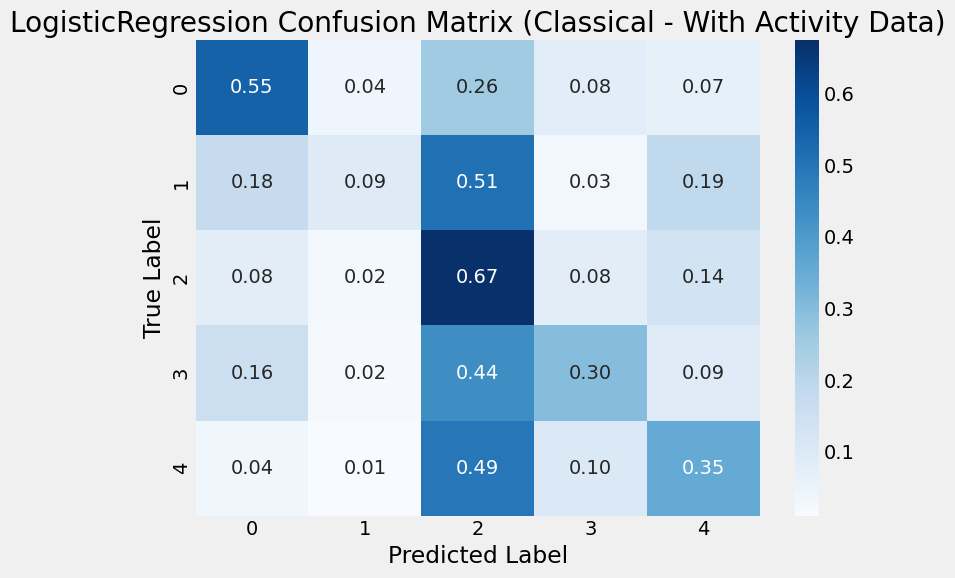


Evaluating LinearSVC...
Train Accuracy: 0.5491
Test Accuracy: 0.5287
Macro Precision: 0.4034
Macro Recall: 0.3966
Macro F1-Score: 0.3823
Test Log Loss: 1.3214


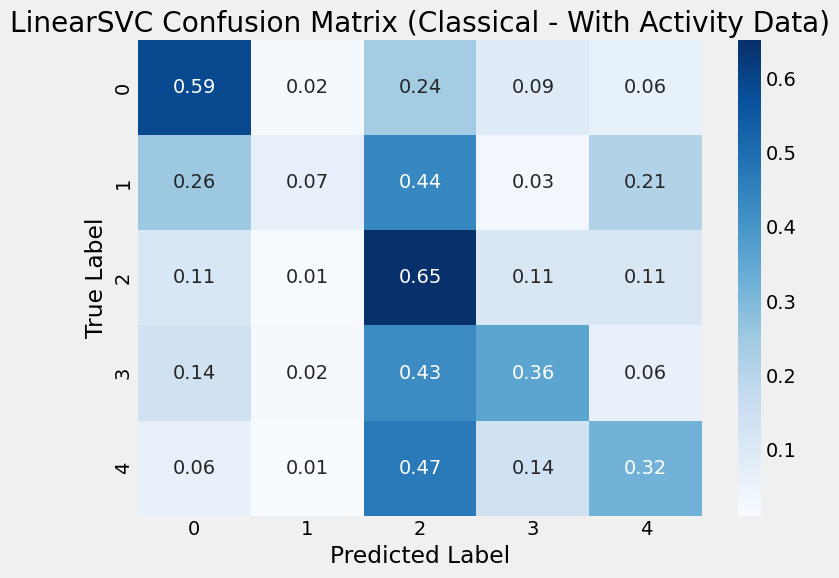


Evaluating DecisionTreeClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.7323
Macro Precision: 0.6494
Macro Recall: 0.6677
Macro F1-Score: 0.6578
Test Log Loss: 9.6479


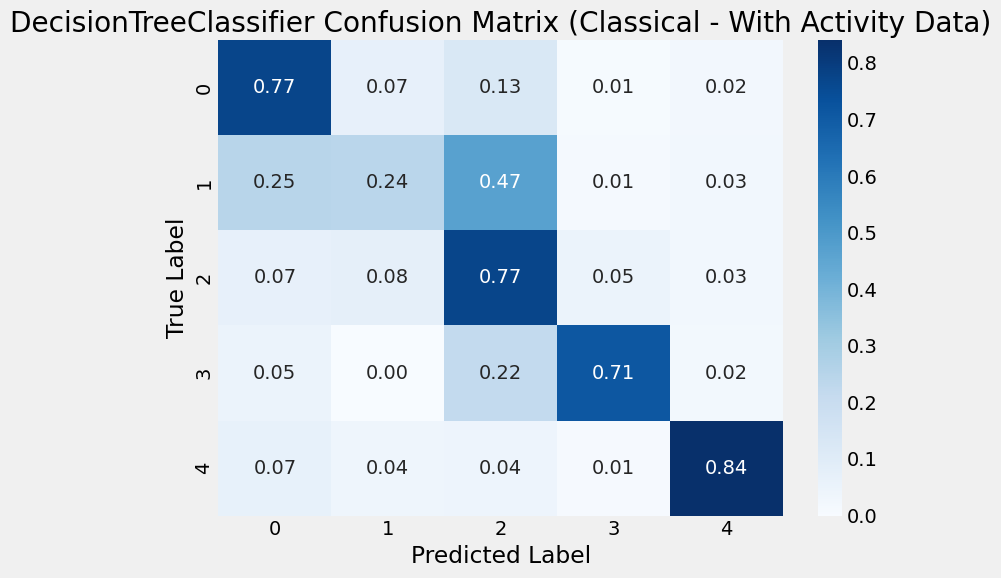


Evaluating ExtraTreesClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.8181
Macro Precision: 0.7415
Macro Recall: 0.7436
Macro F1-Score: 0.7406
Test Log Loss: 0.9034


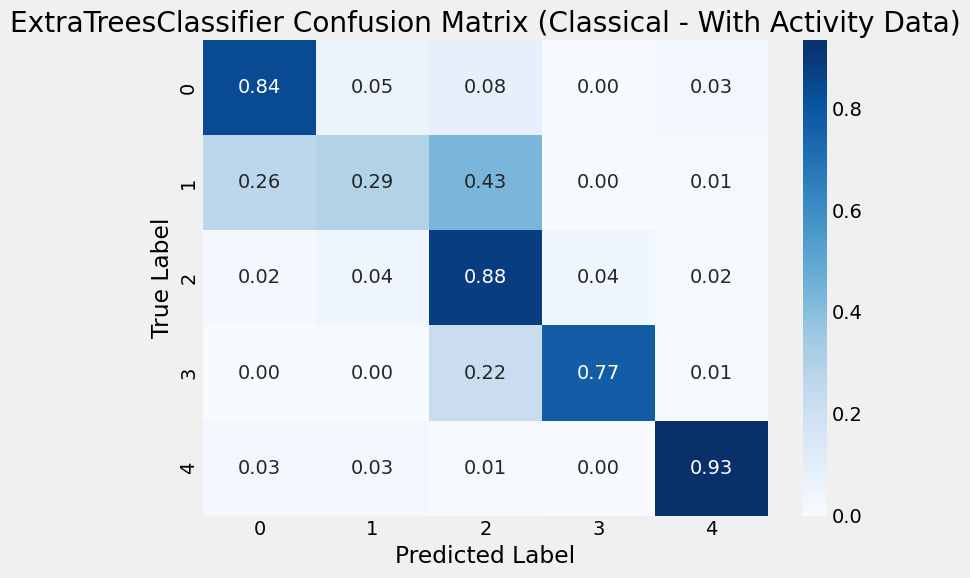


Evaluating RandomForestClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.8248
Macro Precision: 0.7565
Macro Recall: 0.7359
Macro F1-Score: 0.7414
Test Log Loss: 0.6543


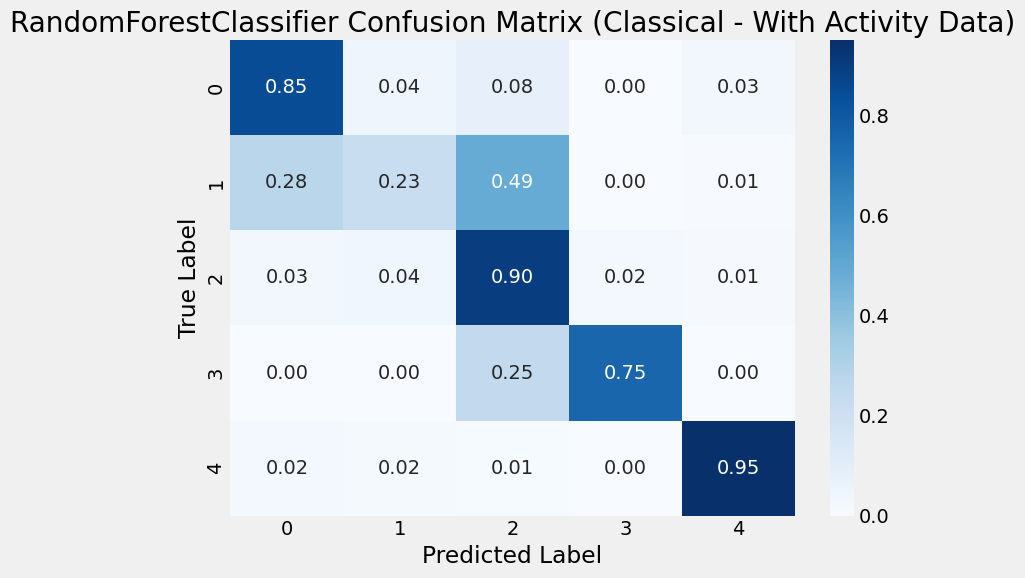


Evaluating XGBClassifier...
Train Accuracy: 0.9704
Test Accuracy: 0.8006
Macro Precision: 0.7390
Macro Recall: 0.7017
Macro F1-Score: 0.7094
Test Log Loss: 0.5574


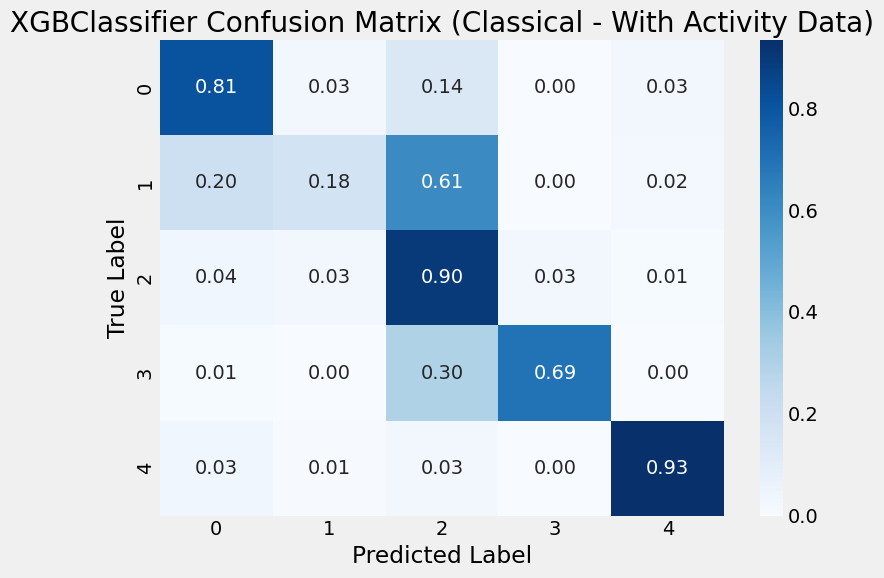


--- Classical Models Results (With Activity Data) ---
                         Scenario              Classifier  Train Accuracy  \
0  Classical - With Activity Data      LogisticRegression        0.537474   
1  Classical - With Activity Data               LinearSVC        0.549108   
2  Classical - With Activity Data  DecisionTreeClassifier        1.000000   
3  Classical - With Activity Data    ExtraTreesClassifier        1.000000   
4  Classical - With Activity Data  RandomForestClassifier        1.000000   
5  Classical - With Activity Data           XGBClassifier        0.970384   

   Test Accuracy  Macro Precision  Macro Recall  Macro F1  Test Log Loss  \
0       0.526888         0.402815      0.393146  0.385747       1.226581   
1       0.528701         0.403364      0.396637  0.382264       1.321402   
2       0.732326         0.649416      0.667692  0.657784       9.647939   
3       0.818127         0.741454      0.743616  0.740579       0.903398   
4       0.824773         

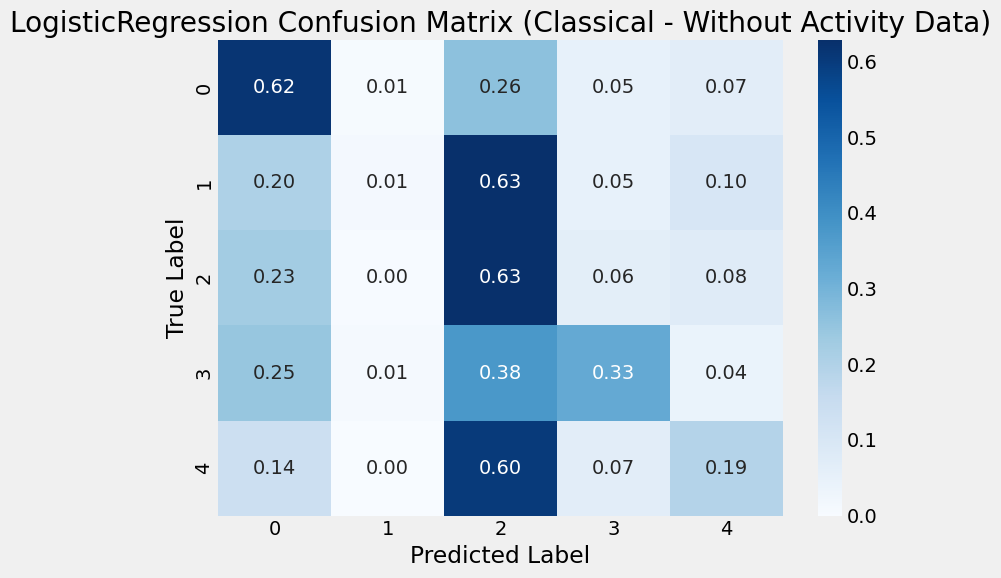


Evaluating LinearSVC...
Train Accuracy: 0.5002
Test Accuracy: 0.5112
Macro Precision: 0.3266
Macro Recall: 0.3460
Macro F1-Score: 0.3334
Test Log Loss: 1.4398


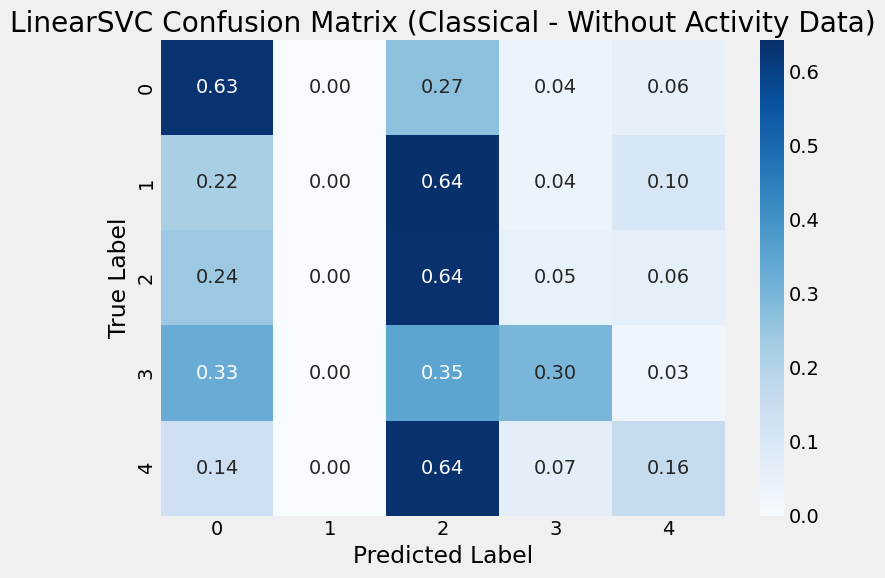


Evaluating DecisionTreeClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.7033
Macro Precision: 0.6138
Macro Recall: 0.6315
Macro F1-Score: 0.6219
Test Log Loss: 10.6933


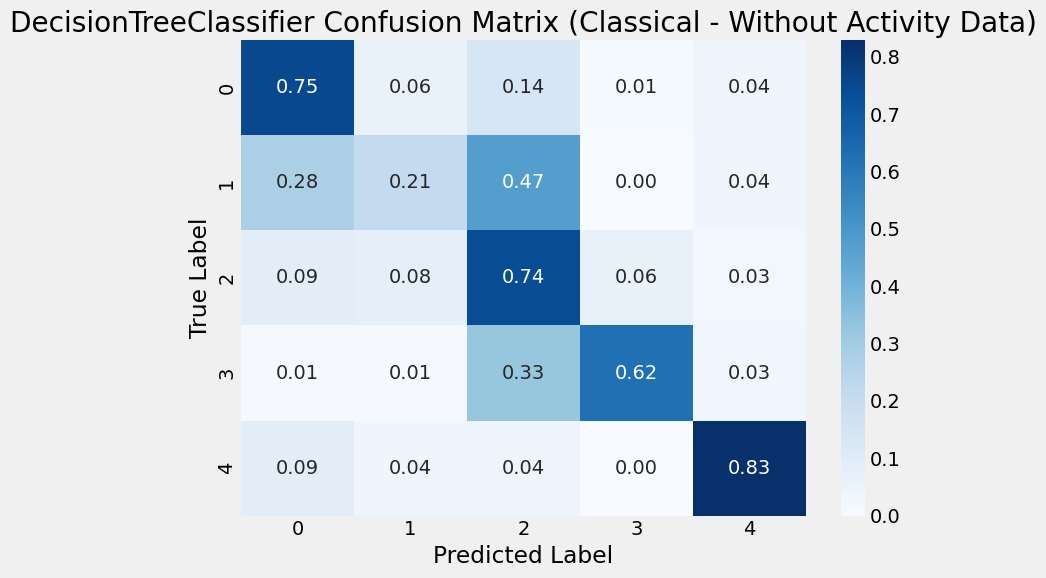


Evaluating ExtraTreesClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.7915
Macro Precision: 0.7265
Macro Recall: 0.7106
Macro F1-Score: 0.7163
Test Log Loss: 1.0441


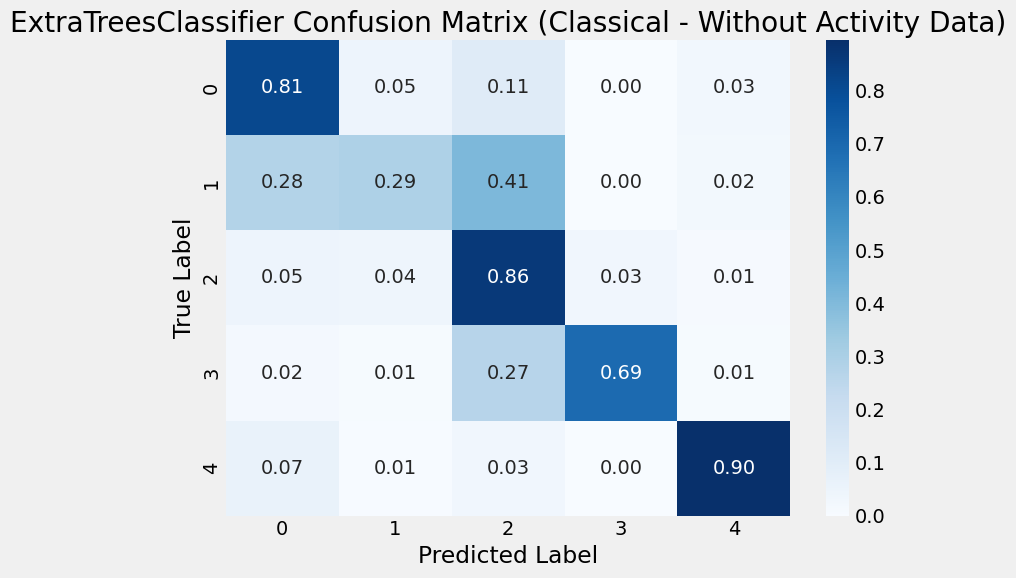


Evaluating RandomForestClassifier...
Train Accuracy: 1.0000
Test Accuracy: 0.8151
Macro Precision: 0.7580
Macro Recall: 0.7137
Macro F1-Score: 0.7268
Test Log Loss: 0.7276


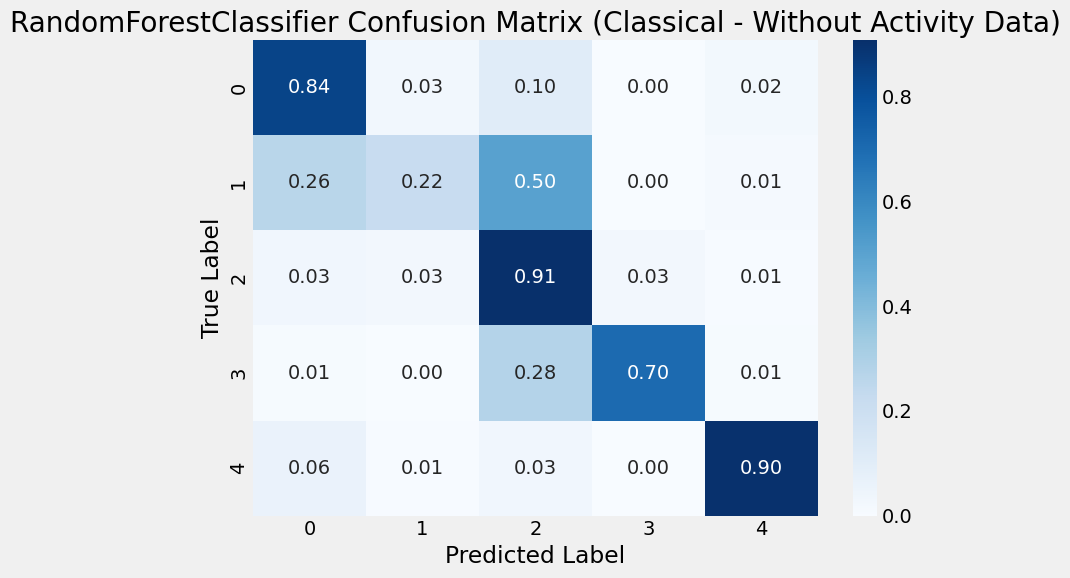


Evaluating XGBClassifier...
Train Accuracy: 0.9660
Test Accuracy: 0.7819
Macro Precision: 0.7245
Macro Recall: 0.6667
Macro F1-Score: 0.6816
Test Log Loss: 0.6041


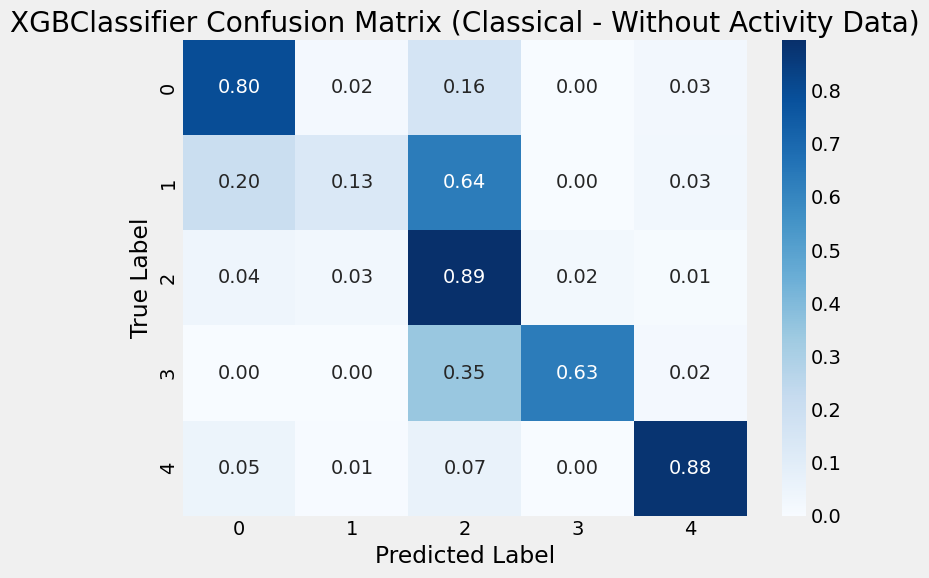


--- Classical Models Results (Without Activity Data) ---
                            Scenario              Classifier  Train Accuracy  \
0  Classical - Without Activity Data      LogisticRegression        0.497129   
1  Classical - Without Activity Data               LinearSVC        0.500151   
2  Classical - Without Activity Data  DecisionTreeClassifier        1.000000   
3  Classical - Without Activity Data    ExtraTreesClassifier        1.000000   
4  Classical - Without Activity Data  RandomForestClassifier        1.000000   
5  Classical - Without Activity Data           XGBClassifier        0.966002   

   Test Accuracy  Macro Precision  Macro Recall  Macro F1  Test Log Loss  \
0       0.506949         0.376225      0.355480  0.343001       1.360626   
1       0.511178         0.326582      0.346018  0.333410       1.439796   
2       0.703323         0.613840      0.631525  0.621942      10.693313   
3       0.791541         0.726466      0.710610  0.716279       1.044085   
4

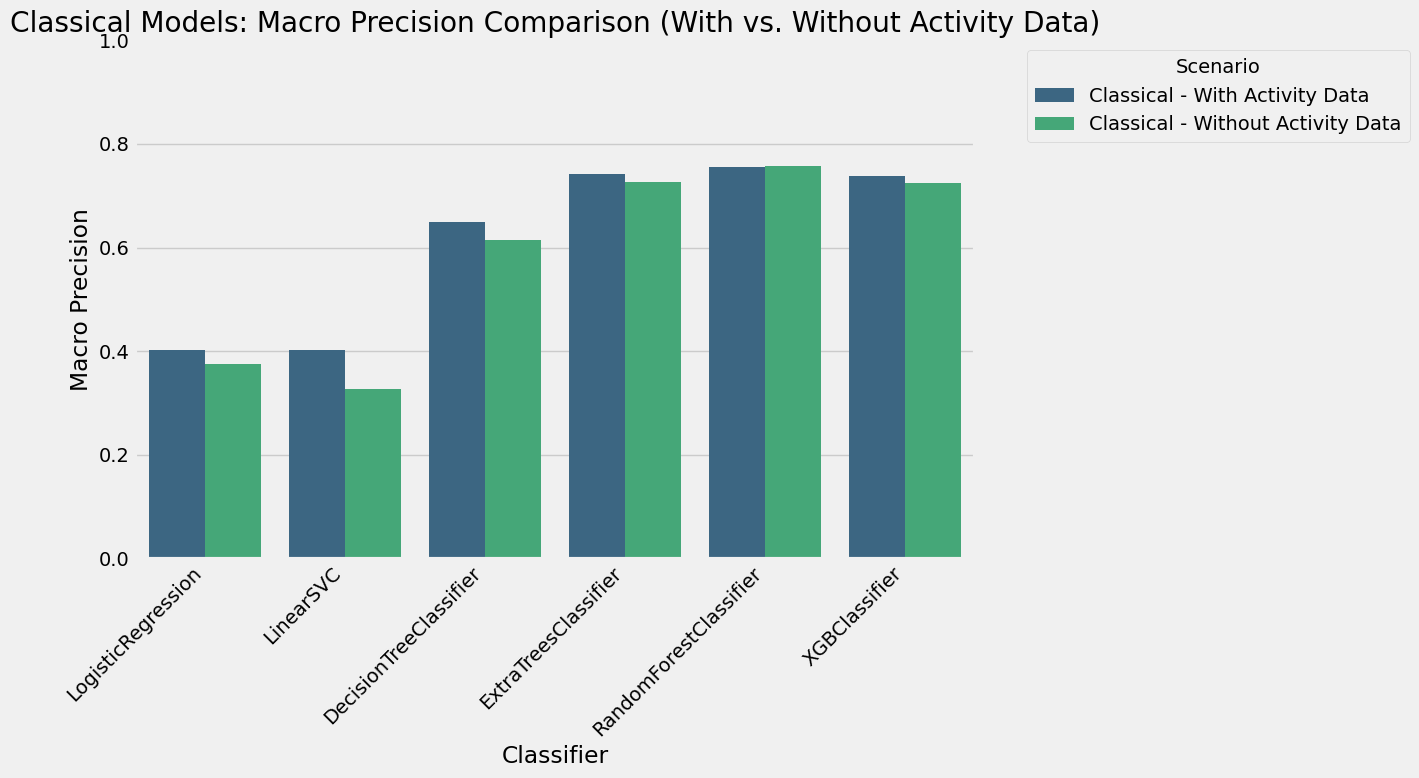

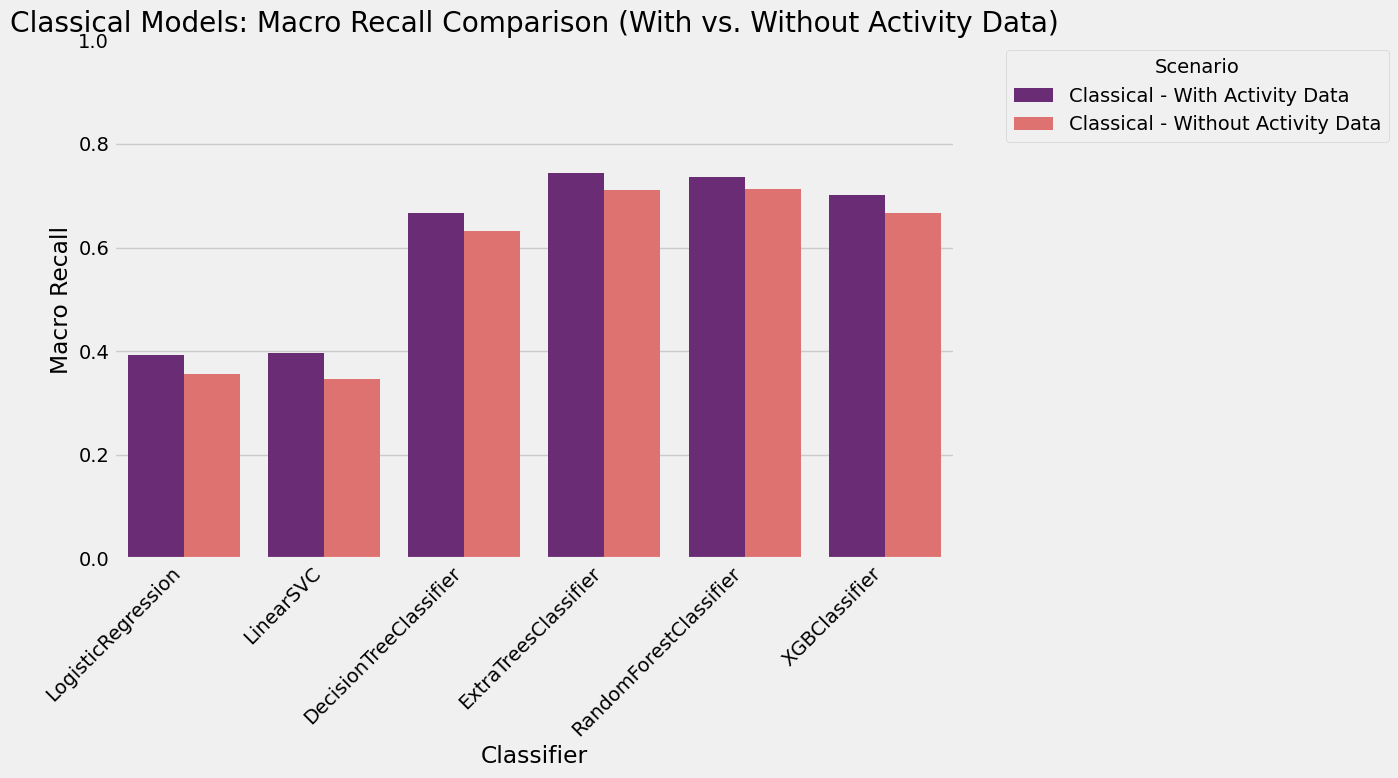

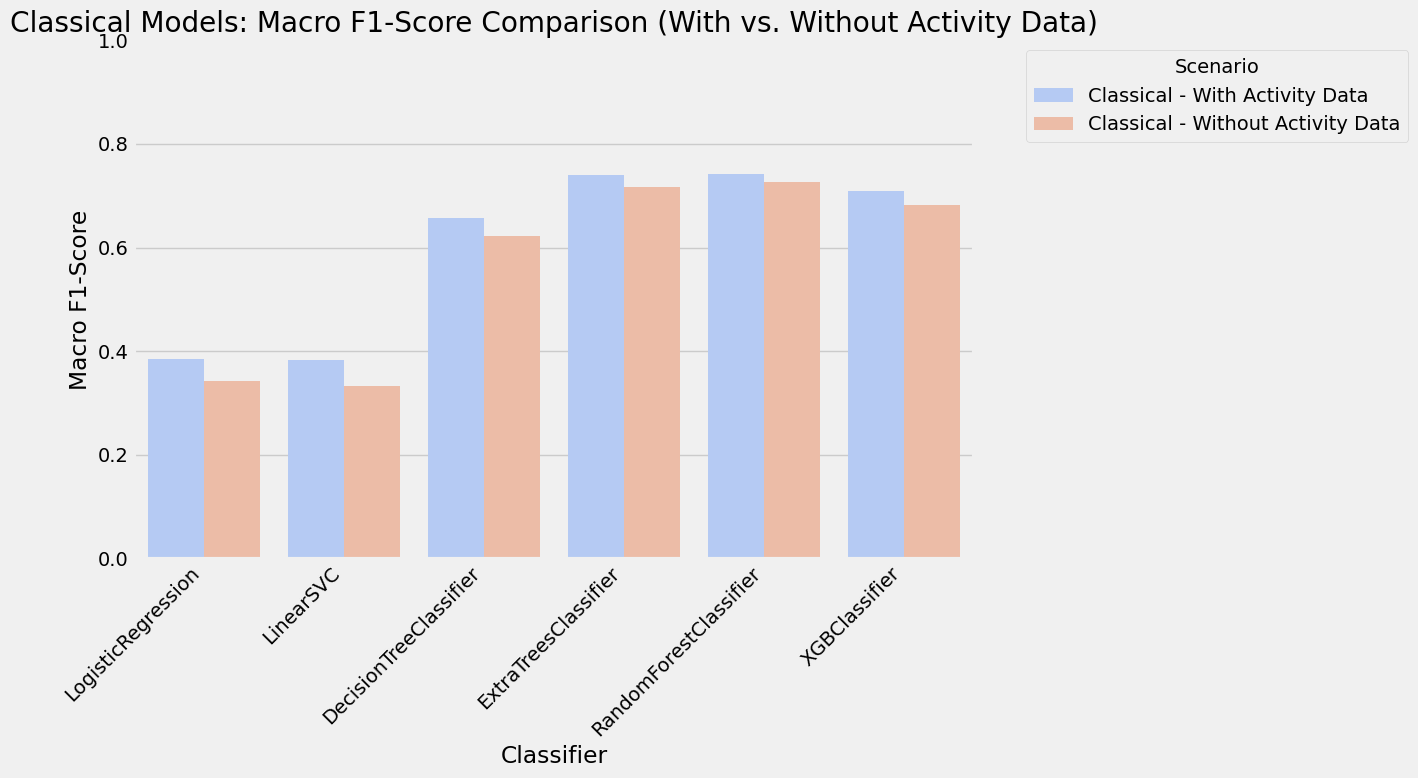

In [12]:
# --- 2. Classical Machine Learning Model Comparison ---

# Function to train and evaluate classical models
def train_evaluate_classical(X_data, y_data, scenario_name, all_results_list):
    print(f"\n--- Running Classical Models: {scenario_name} ---")
    # Stratified split to maintain class proportions
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, stratify=y_data, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models to evaluate
    models = {
        "LogisticRegression": LogisticRegression(class_weight='balanced', n_jobs=-1, solver='liblinear', max_iter=1000, random_state=42),
        "LinearSVC": LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
        "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced', random_state=42),
        "ExtraTreesClassifier": ExtraTreesClassifier(class_weight='balanced', random_state=42),
        "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', random_state=42),
        "XGBClassifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
    }

    class_labels = [str(int(le)) for le in np.unique(y_data)]

    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time

        start_time = time.time()
        y_pred = model.predict(X_test_scaled)
        predict_time = time.time() - start_time

        acc_train = accuracy_score(y_train, model.predict(X_train_scaled))
        acc_test = accuracy_score(y_test, y_pred)

        report = classification_report(y_test, y_pred, output_dict=True)
        macro_precision = report['macro avg']['precision']
        macro_recall = report['macro avg']['recall']
        macro_f1 = report['macro avg']['f1-score']

        loss_test = None
        if hasattr(model, 'predict_proba'):
            y_pred_prob = model.predict_proba(X_test_scaled)
            loss_test = log_loss(y_test, y_pred_prob)
        elif name == "LinearSVC":
            try:
                decision_scores = model.decision_function(X_test_scaled)
                exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
                y_pred_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                loss_test = log_loss(y_test, y_pred_prob)
            except Exception as e:
                print(f"Could not calculate log_loss for {name}: {e}")
                loss_test = np.nan

        print(f"Train Accuracy: {acc_train:.4f}")
        print(f"Test Accuracy: {acc_test:.4f}")
        print(f"Macro Precision: {macro_precision:.4f}")
        print(f"Macro Recall: {macro_recall:.4f}")
        print(f"Macro F1-Score: {macro_f1:.4f}")
        if loss_test is not None:
            print(f"Test Log Loss: {loss_test:.4f}")

        all_results_list.append({
            'Scenario': scenario_name,
            'Classifier': name,
            'Train Accuracy': acc_train,
            'Test Accuracy': acc_test,
            'Macro Precision': macro_precision,
            'Macro Recall': macro_recall,
            'Macro F1': macro_f1,
            'Test Log Loss': loss_test,
            'Train Time (s)': train_time,
            'Predict Time (s)': predict_time
        })

        plt.figure(figsize=(8, 6))
        unique_actual_labels = np.unique(y_test)
        target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
        sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
        plt.title(f'{name} Confusion Matrix ({scenario_name})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

# Scenario 1: With Activity Data (Classical Models)
# Drop 'mesaid' (identifier), 'sleep stage' (original text label), and 'sleep_stage_encoded_5_class' (target)
X_classical_full = df.drop(columns=['mesaid', 'sleep stage', 'sleep_stage_encoded_5_class'], errors='ignore')
y_classical_full = df['sleep_stage_encoded_5_class']

classical_results_all_features = []
train_evaluate_classical(X_classical_full, y_classical_full, "Classical - With Activity Data", classical_results_all_features)
results_df_classical_full = pd.DataFrame(classical_results_all_features)
print("\n--- Classical Models Results (With Activity Data) ---")
print(results_df_classical_full)

# Scenario 2: Without Activity Data (Classical Models)
# Create a copy of X_classical_full and drop activity-related features from it
X_classical_no_activity = X_classical_full.drop(columns=activity_related_features, errors='ignore')
y_classical_no_activity = y_classical_full # Target remains the same

classical_results_no_activity_features = []
train_evaluate_classical(X_classical_no_activity, y_classical_no_activity, "Classical - Without Activity Data", classical_results_no_activity_features)
results_df_classical_no_activity = pd.DataFrame(classical_results_no_activity_features)
print("\n--- Classical Models Results (Without Activity Data) ---")
print(results_df_classical_no_activity)

# --- Compare Classical Models Results ---
comparison_classical_df = pd.concat([results_df_classical_full, results_df_classical_no_activity]).reset_index(drop=True)
print("\n--- Overall Classical Models Comparison ---")
print(comparison_classical_df)

# Visualization for Macro Precision
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_classical_df, x='Classifier', y='Macro Precision', hue='Scenario', palette='viridis')
plt.title('Classical Models: Macro Precision Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro Precision')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for Macro Recall
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_classical_df, x='Classifier', y='Macro Recall', hue='Scenario', palette='magma')
plt.title('Classical Models: Macro Recall Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for Macro F1-Score
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_classical_df, x='Classifier', y='Macro F1', hue='Scenario', palette='coolwarm')
plt.title('Classical Models: Macro F1-Score Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



--- Running Deep Learning Models: DL - With Activity Data ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2636, 1.0: 684, 2.0: 3515, 3.0: 505, 4.0: 903}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...


Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Balanced class distribution: {0.0: 3515, 1.0: 3515, 2.0: 3515, 3.0: 3515, 4.0: 3515}

--- Evaluating LSTM (5-class) ---
LSTM Test Acc: 0.9041, Macro Precision: 0.9087, Macro Recall: 0.9041, Macro F1: 0.9049


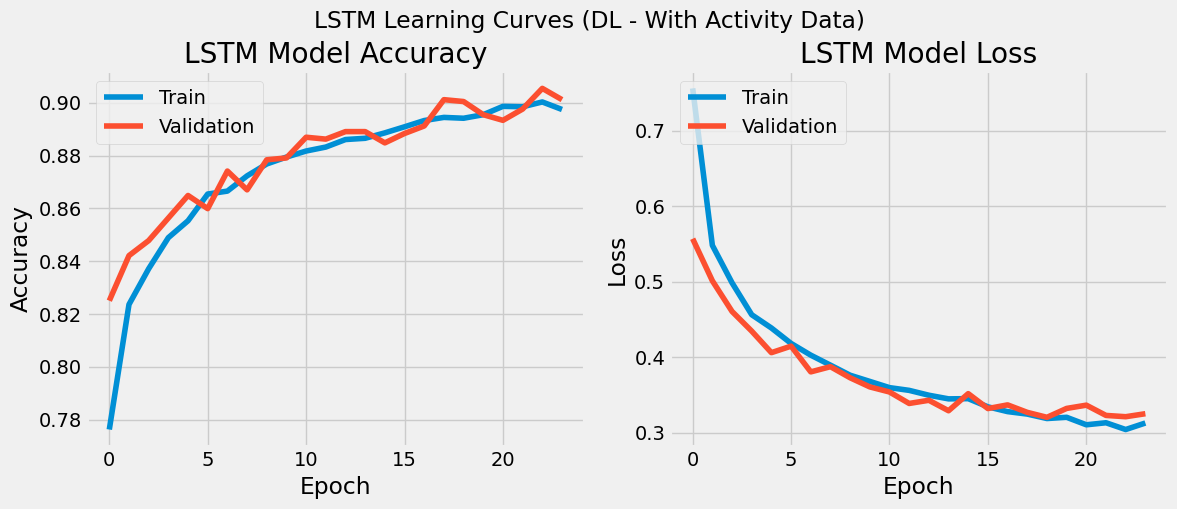

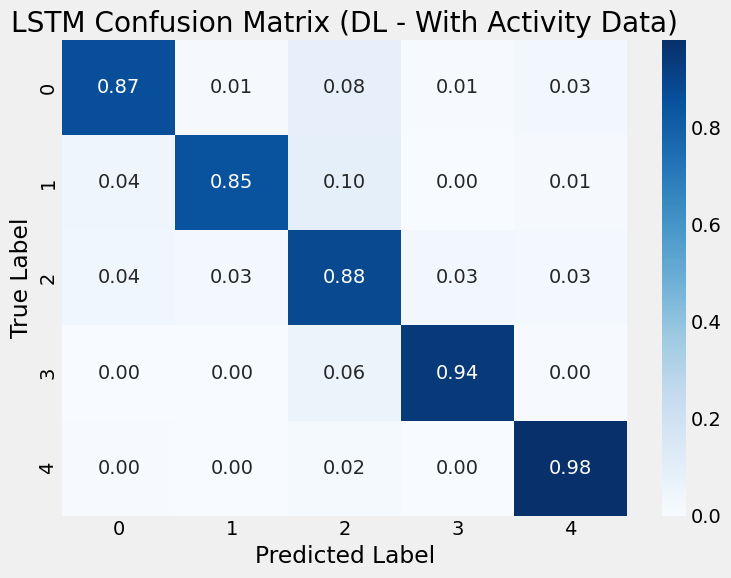


--- Evaluating MLP (5-class) ---
MLP Test Acc: 0.8478, Macro Precision: 0.8948, Macro Recall: 0.8478, Macro F1: 0.8574


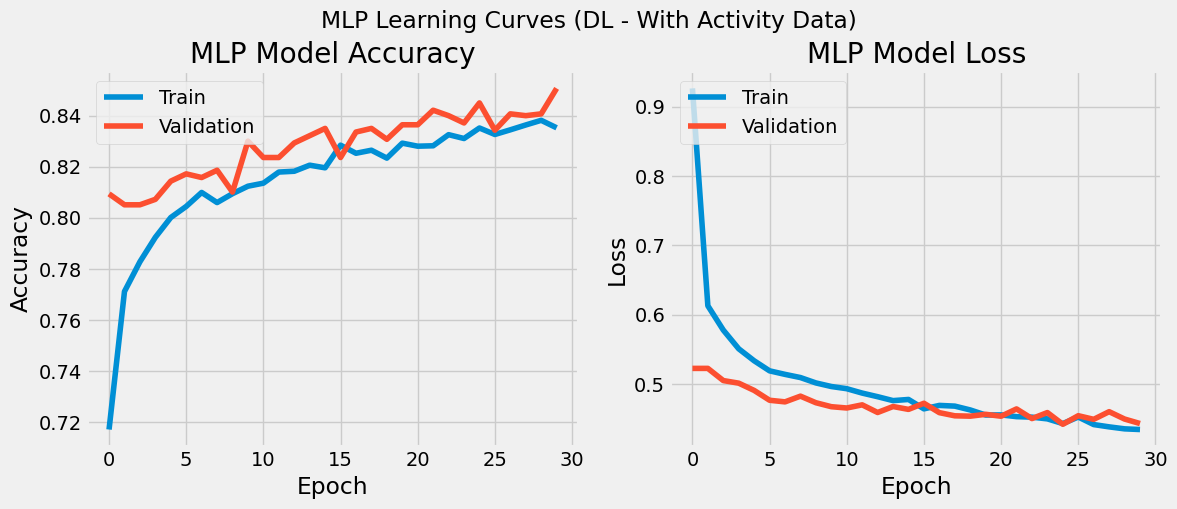

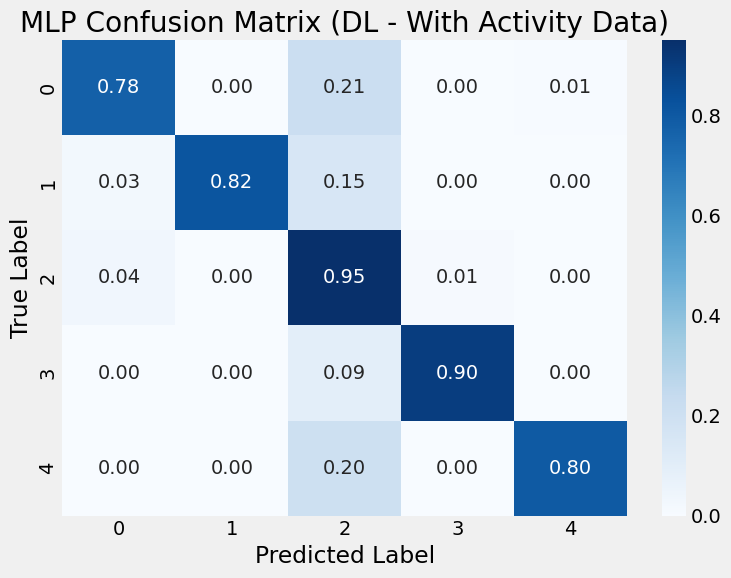


--- Evaluating 1D CNN (5-class) ---
1D CNN Test Acc: 0.8908, Macro Precision: 0.8993, Macro Recall: 0.8908, Macro F1: 0.8921


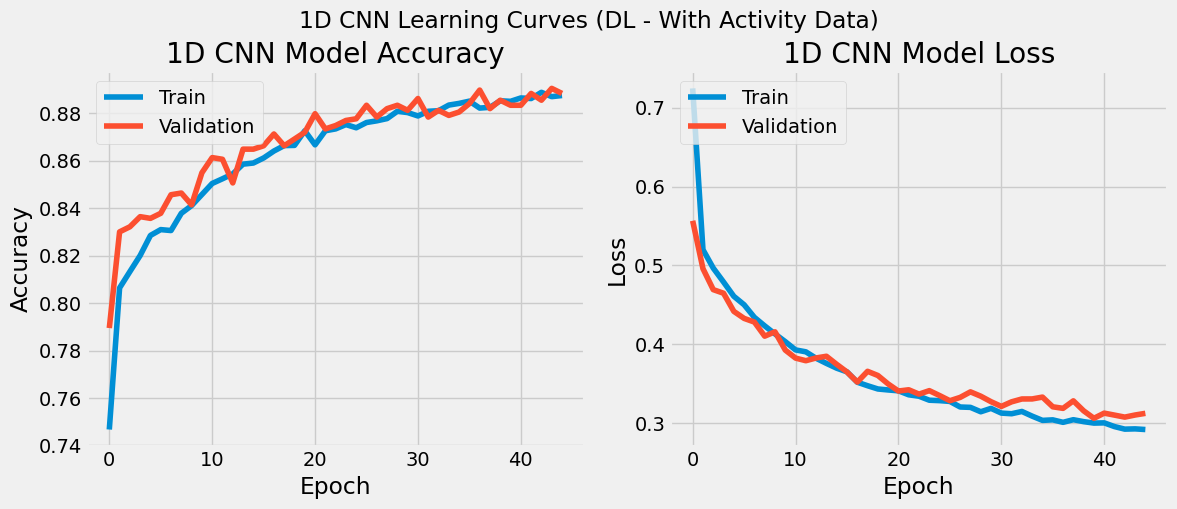

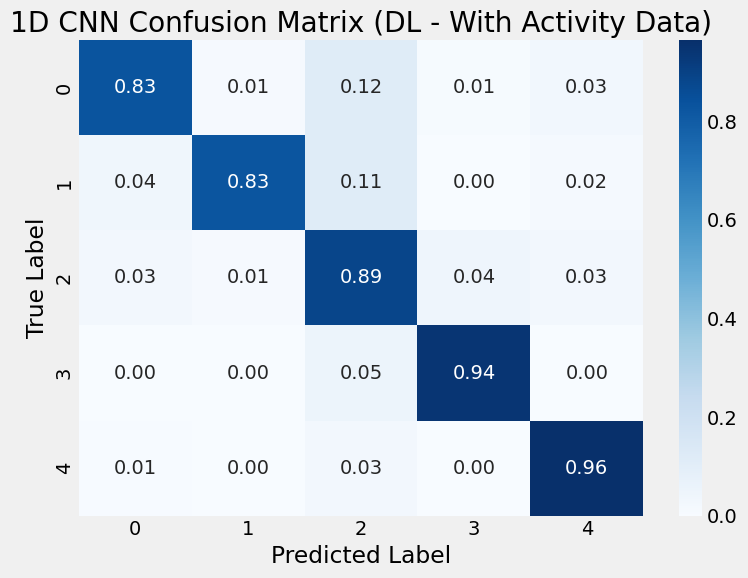


--- Evaluating GRU (5-class) ---
GRU Test Acc: 0.9112, Macro Precision: 0.9152, Macro Recall: 0.9112, Macro F1: 0.9118


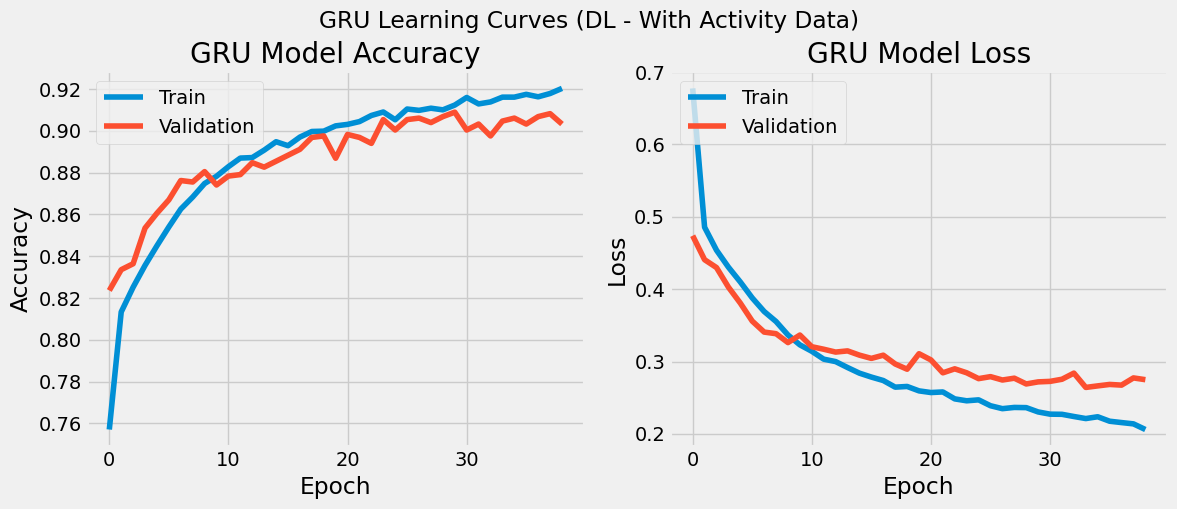

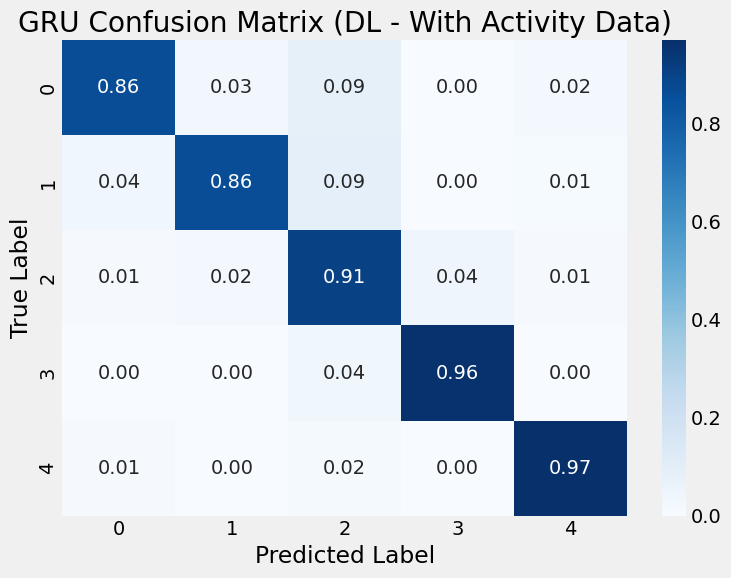


--- Evaluating BiLSTM (3-Class) ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2060, 1.0: 3138, 2.0: 1119}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Balanced class distribution: {0.0: 3138, 1.0: 3138, 2.0: 3138}
BiLSTM Test Acc: 0.4409, Macro Precision: 0.4160, Macro Recall: 0.4307, Macro F1: 0.4085


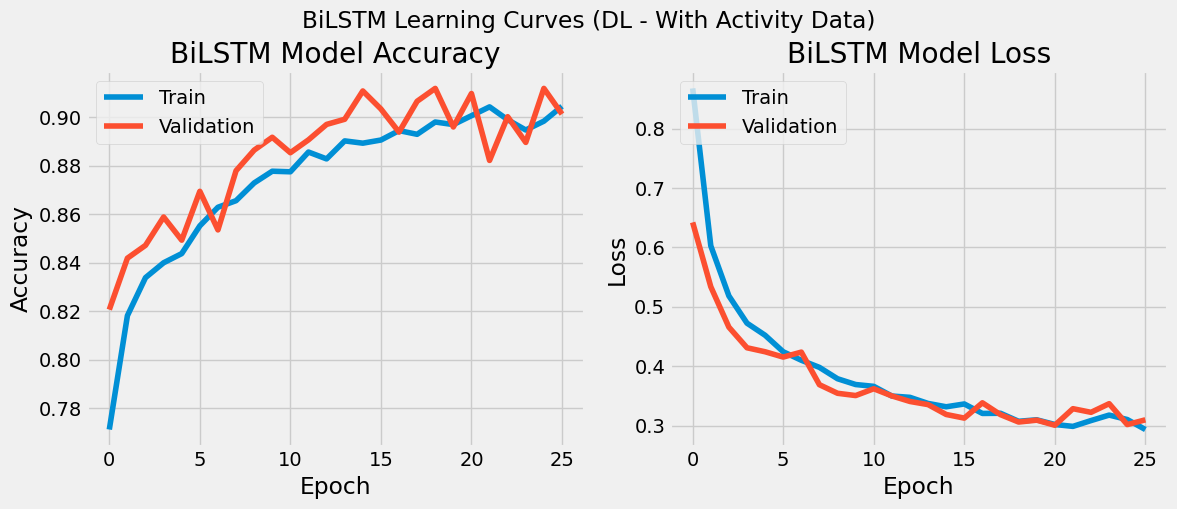

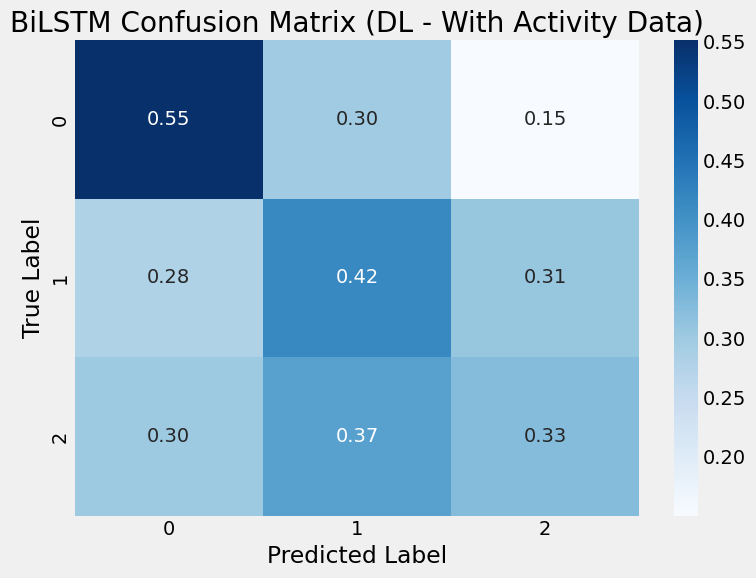


--- Deep Learning Models Results (With Activity Data) ---
                  Scenario   Model  Test Accuracy  Macro Precision  \
0  DL - With Activity Data    LSTM       0.904125         0.908708   
1  DL - With Activity Data     MLP       0.847795         0.894822   
2  DL - With Activity Data  1D CNN       0.890754         0.899274   
3  DL - With Activity Data     GRU       0.911238         0.915181   
4  DL - With Activity Data  BiLSTM       0.440928         0.415994   

   Macro Recall  Macro F1  
0      0.904125  0.904870  
1      0.847795  0.857427  
2      0.890754  0.892081  
3      0.911238  0.911830  
4      0.430729  0.408455  

--- Running Deep Learning Models: DL - Without Activity Data ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2636, 1.0: 684, 2.0: 3515, 3.0: 505, 4.0: 903}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epo

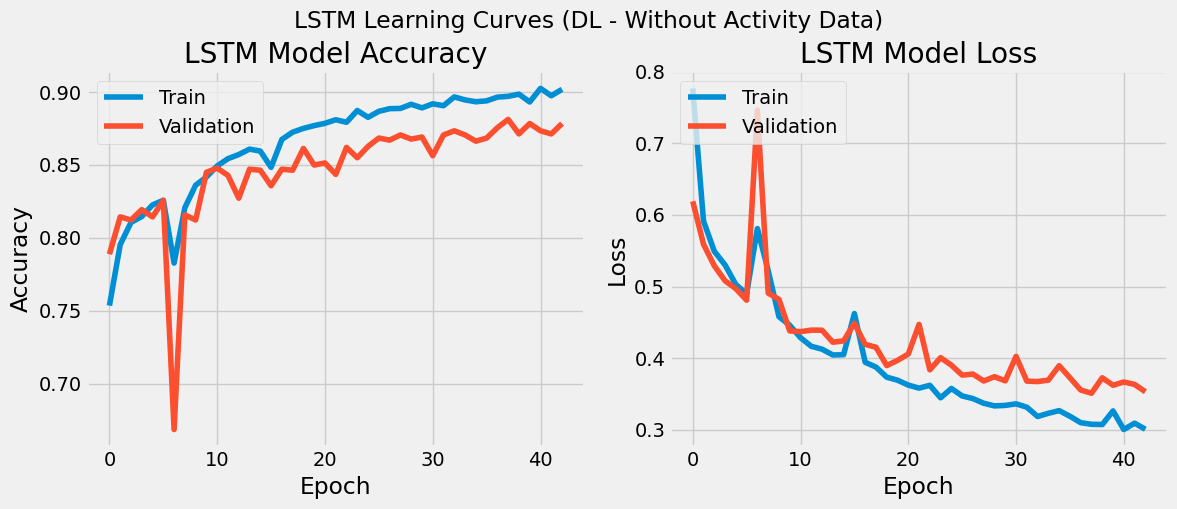

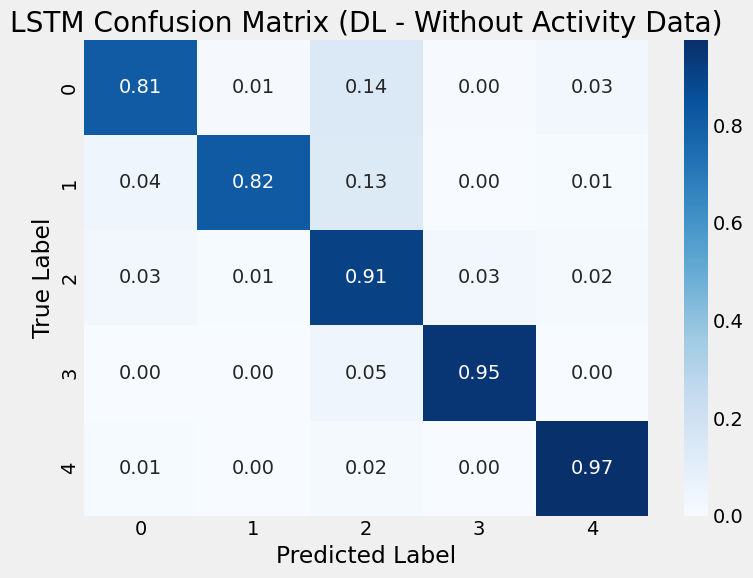


--- Evaluating MLP (5-class) ---
MLP Test Acc: 0.8057, Macro Precision: 0.8742, Macro Recall: 0.8057, Macro F1: 0.8198


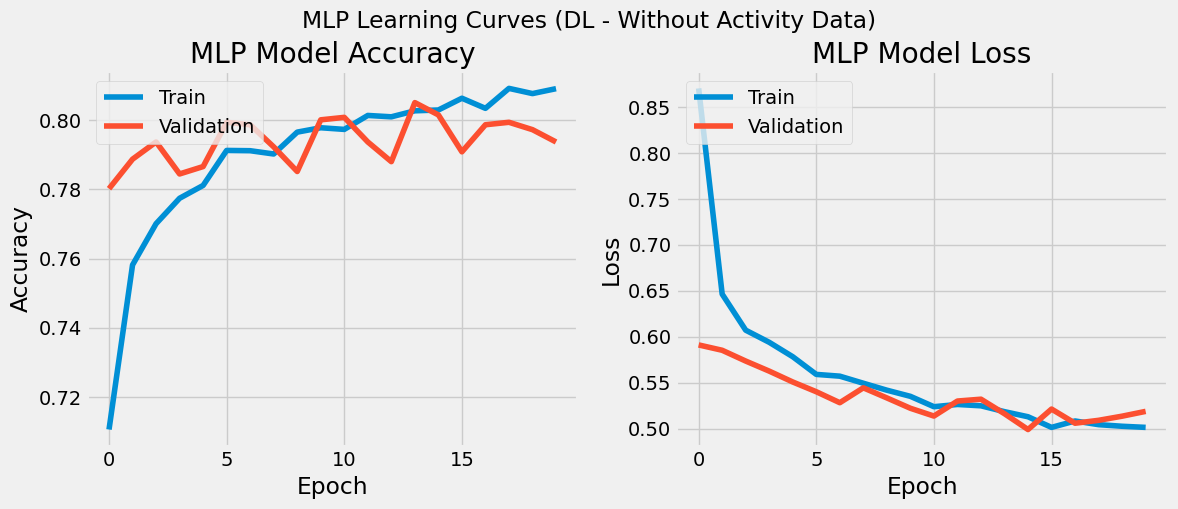

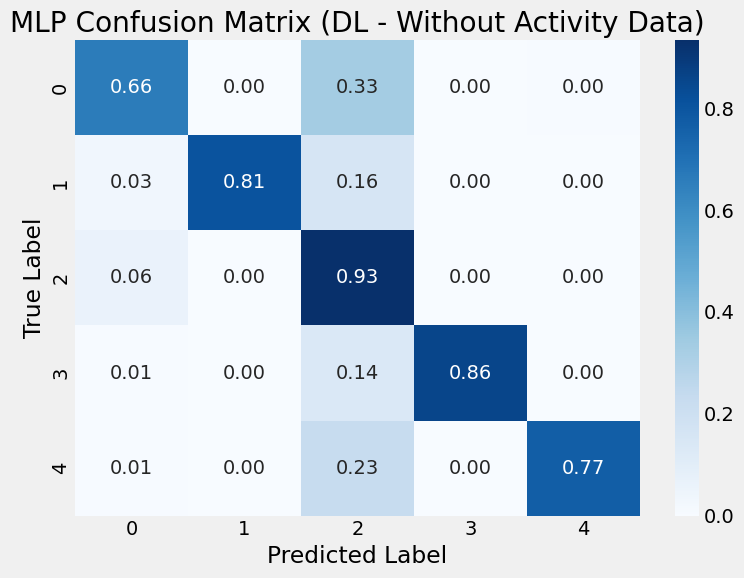


--- Evaluating 1D CNN (5-class) ---
1D CNN Test Acc: 0.8853, Macro Precision: 0.8960, Macro Recall: 0.8853, Macro F1: 0.8865


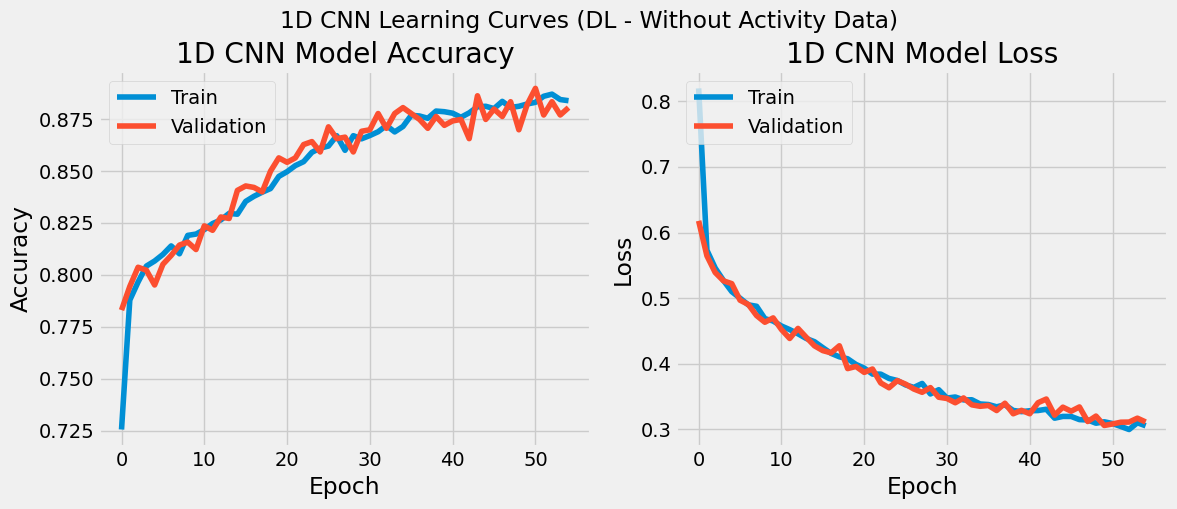

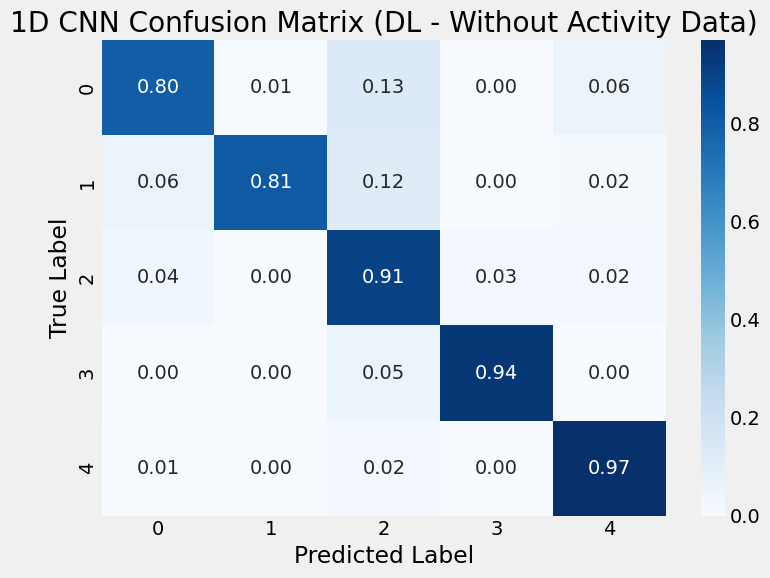


--- Evaluating GRU (5-class) ---
GRU Test Acc: 0.8873, Macro Precision: 0.8989, Macro Recall: 0.8873, Macro F1: 0.8895


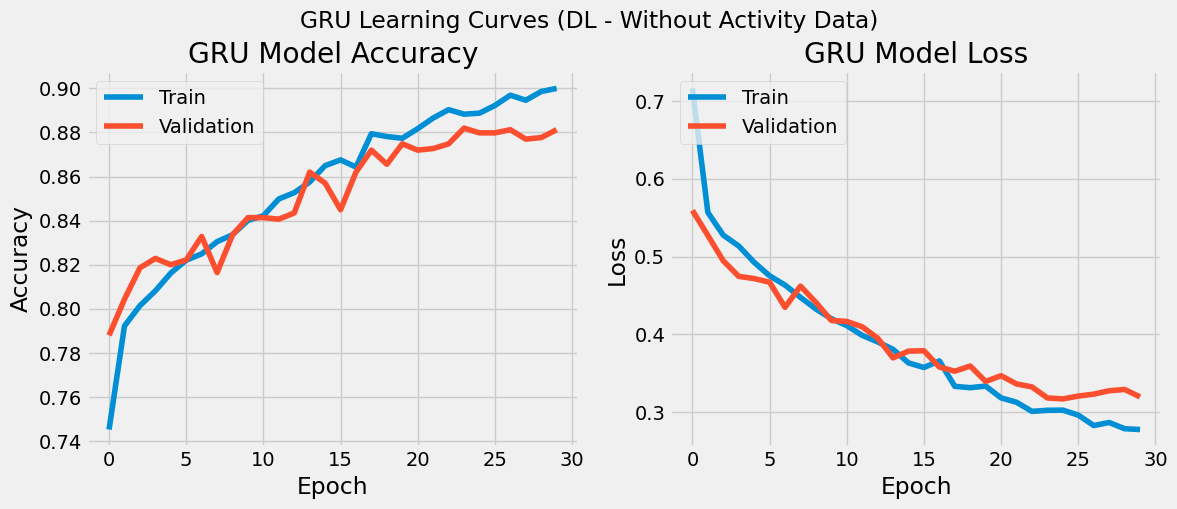

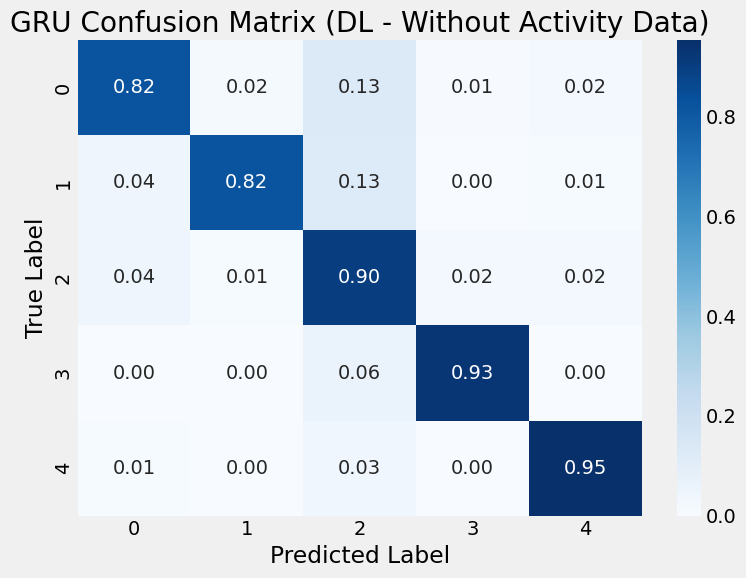


--- Evaluating BiLSTM (3-Class) ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2060, 1.0: 3138, 2.0: 1119}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Balanced class distribution: {0.0: 3138, 1.0: 3138, 2.0: 3138}
BiLSTM Test Acc: 0.3998, Macro Precision: 0.3534, Macro Recall: 0.3653, Macro F1: 0.3202


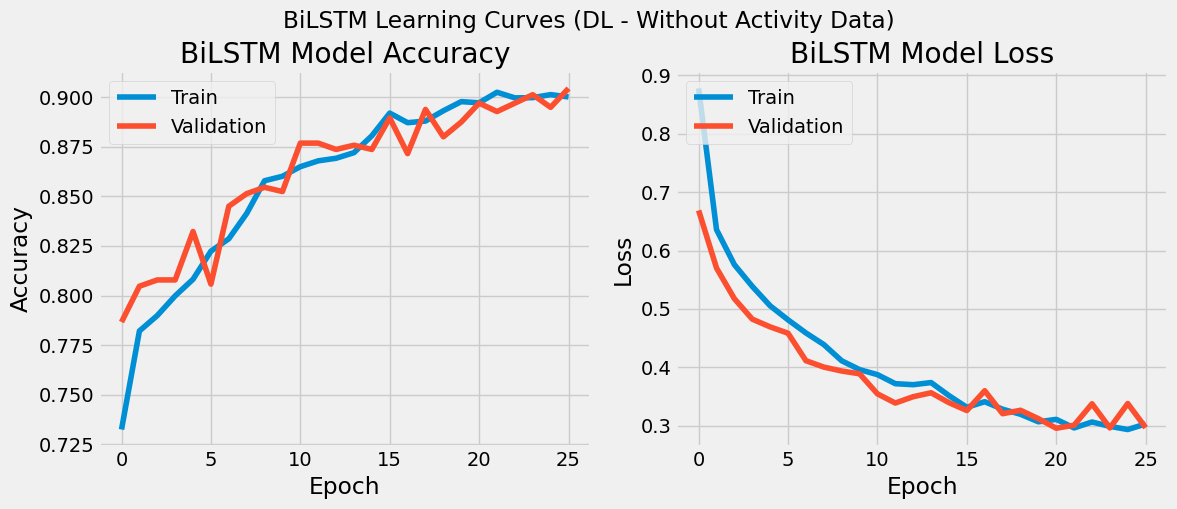

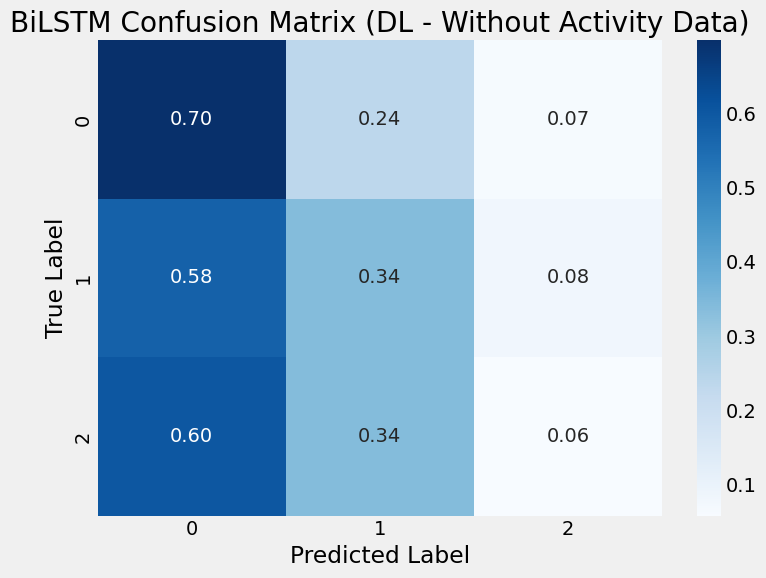


--- Deep Learning Models Results (Without Activity Data) ---
                     Scenario   Model  Test Accuracy  Macro Precision  \
0  DL - Without Activity Data    LSTM       0.892461         0.903027   
1  DL - Without Activity Data     MLP       0.805690         0.874162   
2  DL - Without Activity Data  1D CNN       0.885348         0.895969   
3  DL - Without Activity Data     GRU       0.887340         0.898922   
4  DL - Without Activity Data  BiLSTM       0.399789         0.353351   

   Macro Recall  Macro F1  
0      0.892461  0.893833  
1      0.805690  0.819784  
2      0.885349  0.886550  
3      0.887340  0.889546  
4      0.365309  0.320179  

--- Overall Deep Learning Models Comparison ---
                     Scenario   Model  Test Accuracy  Macro Precision  \
0     DL - With Activity Data    LSTM       0.904125         0.908708   
1     DL - With Activity Data     MLP       0.847795         0.894822   
2     DL - With Activity Data  1D CNN       0.890754         0.

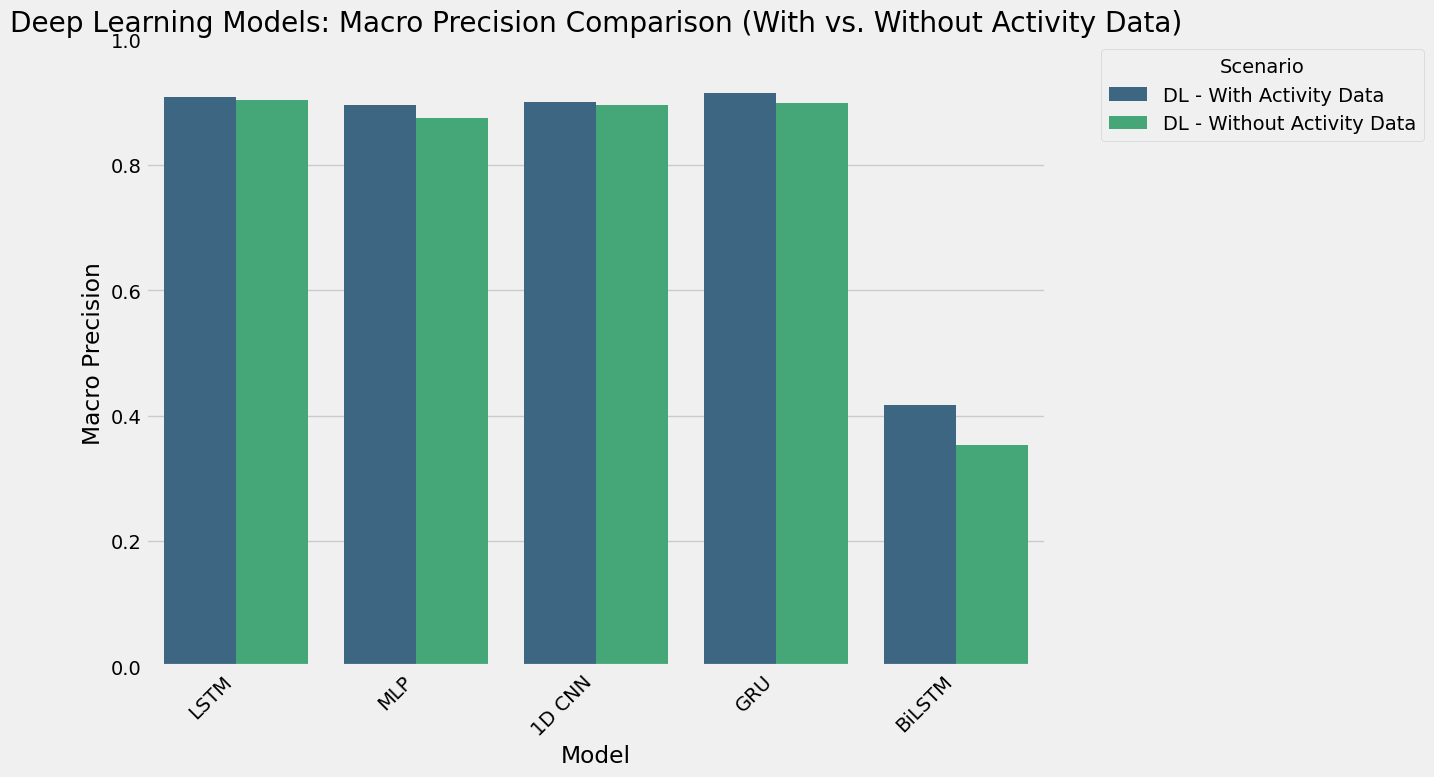

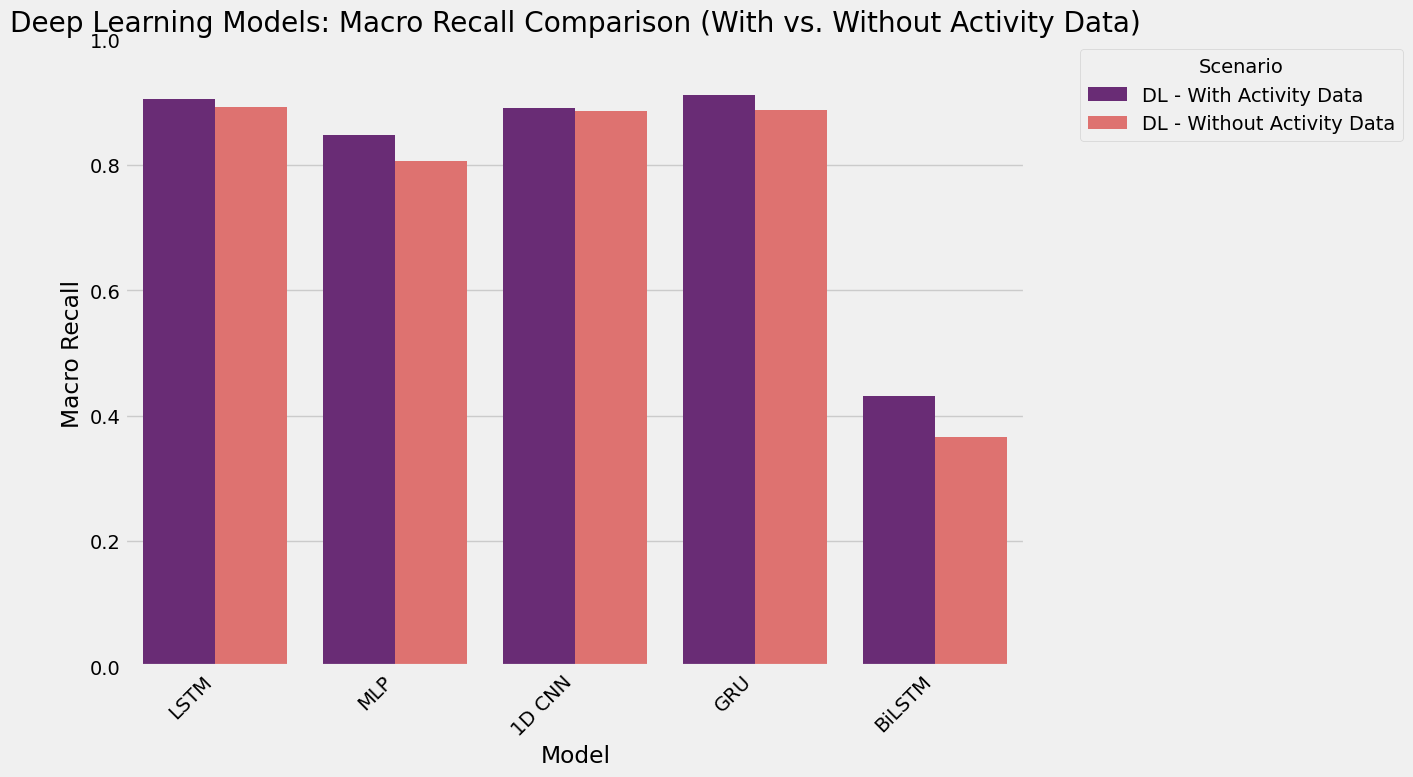

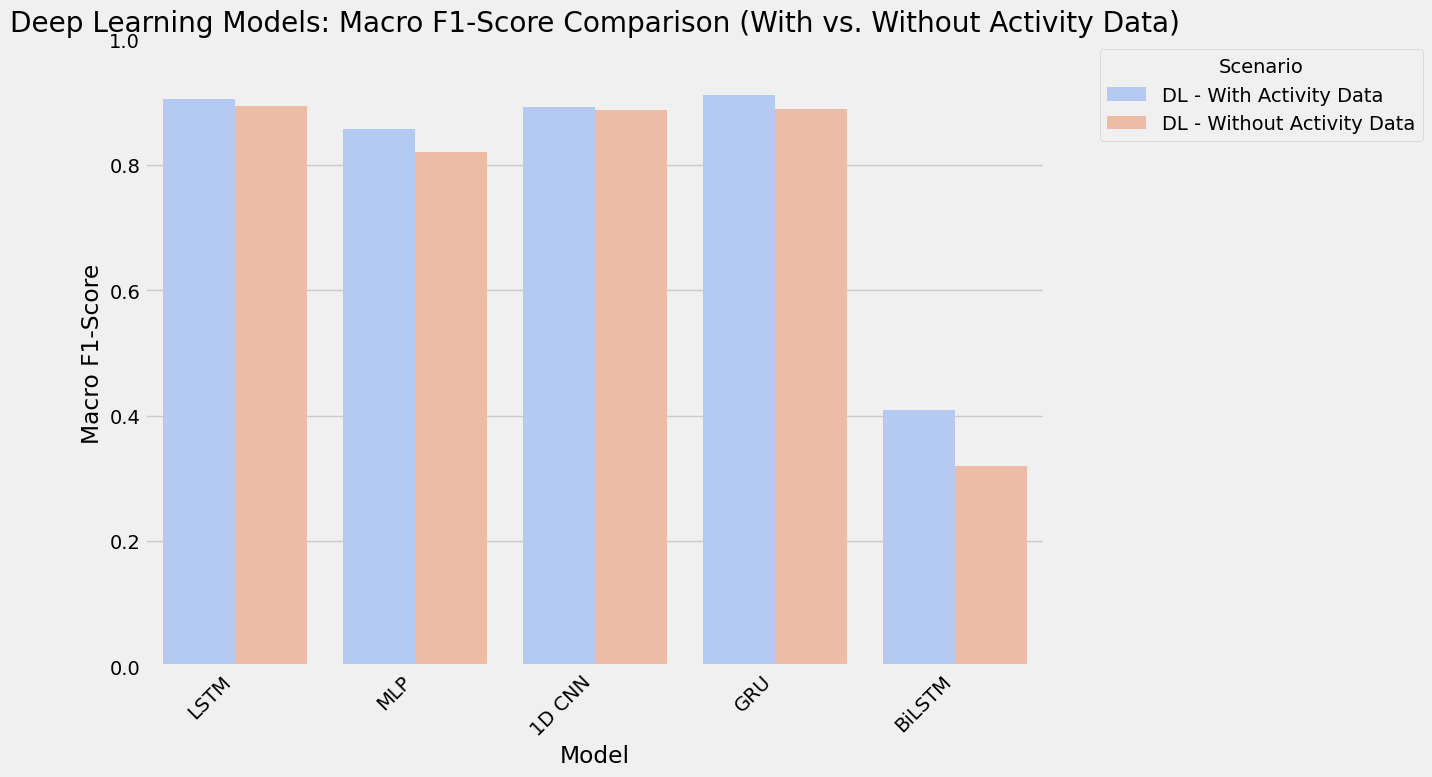

In [13]:
# --- 3. Deep Learning Model Comparison ---

# Helper function to create sequences for DL models
def create_sequences_dl(data_array, seq_length=SEQ_LENGTH, target_idx=-1):
    X, y = [], []
    # Ensure data_array is a numpy array and handle potential errors
    if not isinstance(data_array, np.ndarray):
         data_array = np.array(data_array)

    if data_array.ndim < 2:
        print("Warning: Input data_array for sequences has less than 2 dimensions.")
        return np.array([]), np.array([])

    num_features = data_array.shape[1] - 1 # Assuming target is the last column

    if num_features <= 0:
         print("Warning: Input data_array for sequences has no feature columns besides the target.")
         return np.array([]), np.array([])

    if len(data_array) < seq_length:
        print(f"Warning: Data length ({len(data_array)}) is less than sequence length ({seq_length}). Cannot create sequences.")
        return np.array([]), np.array([])

    for i in range(len(data_array) - seq_length):
        seq_x = data_array[i : i + seq_length, :num_features]
        seq_y = data_array[i + seq_length - 1, target_idx] # Predict the label at the LAST row in this sequence
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


# Function to run and evaluate deep learning models for a given scenario
def train_evaluate_dl(df_input, scenario_name, all_dl_results_list):
    print(f"\n--- Running Deep Learning Models: {scenario_name} ---")

    # Common for 5-class models (LSTM, MLP, 1D CNN, GRU)
    features_5_class_base = [col for col in df_input.columns if col not in ['mesaid', 'sleep stage', 'sleep_stage_encoded_5_class', 'sleep_stage_encoded_3_class']]
    if "Without Activity Data" in scenario_name:
        features_5_class = [f for f in features_5_class_base if f not in activity_related_features]
    else:
        features_5_class = features_5_class_base

    for col in features_5_class:
        if col in df_input.columns:
            df_input[col] = pd.to_numeric(df_input[col], errors='coerce')
            df_input[col].fillna(df_input[col].mean(), inplace=True)
            df_input[col].fillna(0, inplace=True)

    data_array_5_class = df_input[features_5_class + ['sleep_stage_encoded_5_class']].values
    X_seq_5_class, y_seq_5_class = create_sequences_dl(data_array_5_class, seq_length=SEQ_LENGTH, target_idx=-1)

    if X_seq_5_class.size == 0 or y_seq_5_class.size == 0:
        print(f"Skipping 5-class DL models for {scenario_name}: Not enough valid sequences generated.")
        if 'BiLSTM' in [m['Model'] for m in all_dl_results_list if m['Scenario'] == scenario_name]:
            pass
        else:
            return

    n_samples_5, seq_len_5, n_feats_5 = X_seq_5_class.shape
    if n_feats_5 == 0:
        print(f"Skipping 5-class DL models for {scenario_name}: No features available.")
        if 'BiLSTM' in [m['Model'] for m in all_dl_results_list if m['Scenario'] == scenario_name]:
            pass
        else:
            return

    try:
        synthetic_method = 'ctgan' if SDV_AVAILABLE else 'timegan'
        X_res_5, y_res_5 = generate_synthetic_timeseries_data(
            X_seq_5_class, y_seq_5_class,
            target_samples_per_class=None,
            method=synthetic_method
        )
    except Exception as e:
        print(f"Synthetic data generation failed for 5-class models in {scenario_name}: {e}")
        print("Using original data without balancing.")
        X_res_5, y_res_5 = X_seq_5_class, y_seq_5_class

    X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
        X_res_5, y_res_5, test_size=TEST_SIZE, stratify=y_res_5, random_state=RANDOM_SEED
    )

    scaler_5 = StandardScaler()
    X_train_flat_5 = X_train_5.reshape(-1, n_feats_5)
    X_test_flat_5 = X_test_5.reshape(-1, n_feats_5)
    X_train_scaled_5 = scaler_5.fit_transform(X_train_flat_5).reshape(X_train_5.shape)
    X_test_scaled_5 = scaler_5.transform(X_test_flat_5).reshape(X_test_5.shape)

    num_classes_5 = len(np.unique(y_res_5))
    y_train_cat_5 = to_categorical(y_train_5, num_classes_5)
    y_test_cat_5 = to_categorical(y_test_5, num_classes_5)
    class_weights_5 = compute_class_weight('balanced', classes=np.arange(num_classes_5), y=y_train_5)
    class_weights_5 = dict(enumerate(class_weights_5))
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # --- LSTM (5-class) ---
    print("\n--- Evaluating LSTM (5-class) ---")
    model_lstm = Sequential([
        LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, n_feats_5), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes_5, activation='softmax')
    ])
    model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_lstm = model_lstm.fit(X_train_scaled_5, y_train_cat_5, validation_split=0.1, epochs=EPOCHS,
                                  batch_size=BATCH_SIZE, class_weight=class_weights_5, callbacks=[es], verbose=0)
    loss_lstm, acc_lstm = model_lstm.evaluate(X_test_scaled_5, y_test_cat_5, verbose=0)
    y_pred_lstm = np.argmax(model_lstm.predict(X_test_scaled_5, verbose=0), axis=1)
    report_lstm = classification_report(y_test_5, y_pred_lstm, output_dict=True)
    all_dl_results_list.append({
        'Scenario': scenario_name,
        'Model': 'LSTM',
        'Test Accuracy': acc_lstm,
        'Macro Precision': report_lstm['macro avg']['precision'],
        'Macro Recall': report_lstm['macro avg']['recall'],
        'Macro F1': report_lstm['macro avg']['f1-score']
    })
    print(f"LSTM Test Acc: {acc_lstm:.4f}, Macro Precision: {report_lstm['macro avg']['precision']:.4f}, "
          f"Macro Recall: {report_lstm['macro avg']['recall']:.4f}, Macro F1: {report_lstm['macro avg']['f1-score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'])
    plt.plot(history_lstm.history['val_accuracy'])
    plt.title('LSTM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['loss'])
    plt.plot(history_lstm.history['val_loss'])
    plt.title('LSTM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.suptitle(f'LSTM Learning Curves ({scenario_name})', y=1.02)
    plt.show()

    plt.figure(figsize=(8, 6))
    unique_actual_labels = np.unique(y_test_5)
    target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
    sns.heatmap(confusion_matrix(y_test_5, y_pred_lstm, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
    plt.title(f'LSTM Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # --- MLP (5-class) ---
    print("\n--- Evaluating MLP (5-class) ---")
    X_train_mlp_5 = X_train_scaled_5.reshape(X_train_scaled_5.shape[0], -1)
    X_test_mlp_5 = X_test_scaled_5.reshape(X_test_scaled_5.shape[0], -1)
    model_mlp = Sequential([
        Dense(256, activation='relu', input_shape=(seq_len_5*n_feats_5,)), Dropout(0.5),
        Dense(128, activation='relu'), Dropout(0.5), Dense(num_classes_5, activation='softmax')
    ])
    model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_mlp = model_mlp.fit(X_train_mlp_5, y_train_cat_5, validation_split=0.1, epochs=EPOCHS,
                                batch_size=BATCH_SIZE, class_weight=class_weights_5, callbacks=[es], verbose=0)
    loss_mlp, acc_mlp = model_mlp.evaluate(X_test_mlp_5, y_test_cat_5, verbose=0)
    y_pred_mlp = np.argmax(model_mlp.predict(X_test_mlp_5, verbose=0), axis=1)
    report_mlp = classification_report(y_test_5, y_pred_mlp, output_dict=True)
    all_dl_results_list.append({
        'Scenario': scenario_name,
        'Model': 'MLP',
        'Test Accuracy': acc_mlp,
        'Macro Precision': report_mlp['macro avg']['precision'],
        'Macro Recall': report_mlp['macro avg']['recall'],
        'Macro F1': report_mlp['macro avg']['f1-score']
    })
    print(f"MLP Test Acc: {acc_mlp:.4f}, Macro Precision: {report_mlp['macro avg']['precision']:.4f}, "
          f"Macro Recall: {report_mlp['macro avg']['recall']:.4f}, Macro F1: {report_mlp['macro avg']['f1-score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_mlp.history['accuracy'])
    plt.plot(history_mlp.history['val_accuracy'])
    plt.title('MLP Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history_mlp.history['loss'])
    plt.plot(history_mlp.history['val_loss'])
    plt.title('MLP Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.suptitle(f'MLP Learning Curves ({scenario_name})', y=1.02)
    plt.show()

    plt.figure(figsize=(8, 6))
    unique_actual_labels = np.unique(y_test_5)
    target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
    sns.heatmap(confusion_matrix(y_test_5, y_pred_mlp, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
    plt.title(f'MLP Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # --- 1D CNN (5-class) ---
    print("\n--- Evaluating 1D CNN (5-class) ---")
    model_cnn = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, n_feats_5)), Dropout(0.3),
        Conv1D(64, kernel_size=3, activation='relu'), GlobalMaxPooling1D(),
        Dense(128, activation='relu'), Dropout(0.4), Dense(num_classes_5, activation='softmax')
    ])
    model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_cnn = model_cnn.fit(X_train_scaled_5, y_train_cat_5, validation_split=0.1, epochs=EPOCHS,
                                batch_size=BATCH_SIZE, class_weight=class_weights_5, callbacks=[es], verbose=0)
    loss_cnn, acc_cnn = model_cnn.evaluate(X_test_scaled_5, y_test_cat_5, verbose=0)
    y_pred_cnn = np.argmax(model_cnn.predict(X_test_scaled_5, verbose=0), axis=1)
    report_cnn = classification_report(y_test_5, y_pred_cnn, output_dict=True)
    all_dl_results_list.append({
        'Scenario': scenario_name,
        'Model': '1D CNN',
        'Test Accuracy': acc_cnn,
        'Macro Precision': report_cnn['macro avg']['precision'],
        'Macro Recall': report_cnn['macro avg']['recall'],
        'Macro F1': report_cnn['macro avg']['f1-score']
    })
    print(f"1D CNN Test Acc: {acc_cnn:.4f}, Macro Precision: {report_cnn['macro avg']['precision']:.4f}, "
          f"Macro Recall: {report_cnn['macro avg']['recall']:.4f}, Macro F1: {report_cnn['macro avg']['f1-score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_cnn.history['accuracy'])
    plt.plot(history_cnn.history['val_accuracy'])
    plt.title('1D CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history_cnn.history['loss'])
    plt.plot(history_cnn.history['val_loss'])
    plt.title('1D CNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.suptitle(f'1D CNN Learning Curves ({scenario_name})', y=1.02)
    plt.show()

    plt.figure(figsize=(8, 6))
    unique_actual_labels = np.unique(y_test_5)
    target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
    sns.heatmap(confusion_matrix(y_test_5, y_pred_cnn, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
    plt.title(f'1D CNN Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # --- GRU (5-class) ---
    print("\n--- Evaluating GRU (5-class) ---")
    model_gru = Sequential([
        GRU(64, return_sequences=True, input_shape=(SEQ_LENGTH, n_feats_5)), Dropout(0.3),
        GRU(64), Dropout(0.3), Dense(32, activation='relu'),
        Dense(num_classes_5, activation='softmax')
    ])
    model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_gru = model_gru.fit(X_train_scaled_5, y_train_cat_5, validation_split=0.1, epochs=EPOCHS,
                                batch_size=BATCH_SIZE, class_weight=class_weights_5, callbacks=[es], verbose=0)
    loss_gru, acc_gru = model_gru.evaluate(X_test_scaled_5, y_test_cat_5, verbose=0)
    y_pred_gru = np.argmax(model_gru.predict(X_test_scaled_5, verbose=0), axis=1)
    report_gru = classification_report(y_test_5, y_pred_gru, output_dict=True)
    all_dl_results_list.append({
        'Scenario': scenario_name,
        'Model': 'GRU',
        'Test Accuracy': acc_gru,
        'Macro Precision': report_gru['macro avg']['precision'],
        'Macro Recall': report_gru['macro avg']['recall'],
        'Macro F1': report_gru['macro avg']['f1-score']
    })
    print(f"GRU Test Acc: {acc_gru:.4f}, Macro Precision: {report_gru['macro avg']['precision']:.4f}, "
          f"Macro Recall: {report_gru['macro avg']['recall']:.4f}, Macro F1: {report_gru['macro avg']['f1-score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_gru.history['accuracy'])
    plt.plot(history_gru.history['val_accuracy'])
    plt.title('GRU Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history_gru.history['loss'])
    plt.plot(history_gru.history['val_loss'])
    plt.title('GRU Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.suptitle(f'GRU Learning Curves ({scenario_name})', y=1.02)
    plt.show()

    plt.figure(figsize=(8, 6))
    unique_actual_labels = np.unique(y_test_5)
    target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
    sns.heatmap(confusion_matrix(y_test_5, y_pred_gru, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
    plt.title(f'GRU Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # --- BiLSTM (3-class) ---
    print("\n--- Evaluating BiLSTM (3-Class) ---")
    df_bilstm_3class = df_input.copy()
    stage_map_3_class = {0.:0, 1.:1, 2.:1, 3.:2, 5.:2}
    df_bilstm_3class['sleep_stage_encoded_3_class'] = df_bilstm_3class['sleep stage'].map(stage_map_3_class)
    df_bilstm_3class.dropna(subset=['sleep_stage_encoded_3_class'], inplace=True)
    df_bilstm_3class['sleep_stage_encoded_3_class'] = df_bilstm_3class['sleep_stage_encoded_3_class'].astype(int)

    features_bilstm_base = [col for col in df_bilstm_3class.columns if col not in ['mesaid', 'sleep stage', 'sleep_stage_encoded_5_class', 'sleep_stage_encoded_3_class']]
    if "Without Activity Data" in scenario_name:
        features_bilstm = [f for f in features_bilstm_base if f not in activity_related_features]
    else:
        features_bilstm = features_bilstm_base

    for col in features_bilstm:
        if col in df_bilstm_3class.columns:
            df_bilstm_3class[col] = pd.to_numeric(df_bilstm_3class[col], errors='coerce')
            df_bilstm_3class[col].fillna(df_bilstm_3class[col].mean(), inplace=True)
            df_bilstm_3class[col].fillna(0, inplace=True)

    unique_mesaids_bilstm = df_bilstm_3class['mesaid'].unique()
    if len(unique_mesaids_bilstm) < 2:
        print(f"Skipping BiLSTM for {scenario_name}: Not enough unique 'mesaid' for group split.")
        return

    gss_bilstm = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    train_idx_bilstm, test_idx_bilstm = next(gss_bilstm.split(df_bilstm_3class, groups=df_bilstm_3class['mesaid']))
    train_df_bilstm = df_bilstm_3class.iloc[train_idx_bilstm].copy()
    test_df_bilstm = df_bilstm_3class.iloc[test_idx_bilstm].copy()

    X_train_bilstm, y_train_bilstm = create_sequences_dl(train_df_bilstm[features_bilstm + ['sleep_stage_encoded_3_class']].values, target_idx=-1)
    X_test_bilstm, y_test_bilstm = create_sequences_dl(test_df_bilstm[features_bilstm + ['sleep_stage_encoded_3_class']].values, target_idx=-1)

    if X_train_bilstm.size == 0 or X_test_bilstm.size == 0:
        print(f"Skipping BiLSTM for {scenario_name}: Not enough sequences after group split.")
        return

    try:
        synthetic_method = 'ctgan' if SDV_AVAILABLE else 'timegan'
        X_train_bilstm_balanced, y_train_bilstm_balanced = generate_synthetic_timeseries_data(
            X_train_bilstm, y_train_bilstm,
            target_samples_per_class=None,
            method=synthetic_method
        )
    except Exception as e:
        print(f"Synthetic data generation failed for BiLSTM in {scenario_name}: {e}")
        print("Using simple oversampling for BiLSTM.")
        unique_classes_bilstm, class_counts_bilstm = np.unique(y_train_bilstm, return_counts=True)
        max_count_bilstm = class_counts_bilstm.max()
        X_balanced_bilstm, y_balanced_bilstm = [], []
        for cls in unique_classes_bilstm:
            Xi = X_train_bilstm[y_train_bilstm == cls]
            yi = y_train_bilstm[y_train_bilstm == cls]
            if len(yi) > 0:
                if len(yi) < max_count_bilstm:
                    Xi_resampled, yi_resampled = resample(Xi, yi, replace=True, n_samples=max_count_bilstm, random_state=RANDOM_SEED)
                    X_balanced_bilstm.append(Xi_resampled)
                    y_balanced_bilstm.append(yi_resampled)
                else:
                    X_balanced_bilstm.append(Xi)
                    y_balanced_bilstm.append(yi)

        if not X_balanced_bilstm:
            print(f"Skipping BiLSTM for {scenario_name}: No data for oversampling after split.")
            return

        X_train_bilstm_balanced = np.vstack(X_balanced_bilstm)
        y_train_bilstm_balanced = np.concatenate(y_balanced_bilstm)

    scaler_bilstm = StandardScaler()
    n_features_bilstm = X_train_bilstm_balanced.shape[2]
    X_train_bilstm_scaled = scaler_bilstm.fit_transform(X_train_bilstm_balanced.reshape(-1, n_features_bilstm)).reshape(-1, SEQ_LENGTH, n_features_bilstm)
    X_test_bilstm_scaled = scaler_bilstm.transform(X_test_bilstm.reshape(-1, n_features_bilstm)).reshape(-1, SEQ_LENGTH, n_features_bilstm)

    num_classes_bilstm = len(np.unique(y_train_bilstm_balanced))
    y_train_bilstm_cat = to_categorical(y_train_bilstm_balanced, num_classes_bilstm)
    y_test_bilstm_cat = to_categorical(y_test_bilstm, num_classes_bilstm)

    model_bilstm = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)), input_shape=(SEQ_LENGTH, n_features_bilstm)),
        Dropout(0.4),
        Bidirectional(LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.001))),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dense(num_classes_bilstm, activation='softmax')
    ])
    model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_bilstm = model_bilstm.fit(X_train_bilstm_scaled, y_train_bilstm_cat, validation_split=0.1, epochs=EPOCHS,
                                      batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    loss_bilstm, acc_bilstm = model_bilstm.evaluate(X_test_bilstm_scaled, y_test_bilstm_cat, verbose=0)
    y_pred_bilstm = np.argmax(model_bilstm.predict(X_test_bilstm_scaled, verbose=0), axis=1)
    report_bilstm = classification_report(y_test_bilstm, y_pred_bilstm, output_dict=True)
    all_dl_results_list.append({
        'Scenario': scenario_name,
        'Model': 'BiLSTM',
        'Test Accuracy': acc_bilstm,
        'Macro Precision': report_bilstm['macro avg']['precision'],
        'Macro Recall': report_bilstm['macro avg']['recall'],
        'Macro F1': report_bilstm['macro avg']['f1-score']
    })
    print(f"BiLSTM Test Acc: {acc_bilstm:.4f}, Macro Precision: {report_bilstm['macro avg']['precision']:.4f}, "
          f"Macro Recall: {report_bilstm['macro avg']['recall']:.4f}, Macro F1: {report_bilstm['macro avg']['f1-score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_bilstm.history['accuracy'])
    plt.plot(history_bilstm.history['val_accuracy'])
    plt.title('BiLSTM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history_bilstm.history['loss'])
    plt.plot(history_bilstm.history['val_loss'])
    plt.title('BiLSTM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.suptitle(f'BiLSTM Learning Curves ({scenario_name})', y=1.02)
    plt.show()

    plt.figure(figsize=(8, 6))
    unique_actual_labels = np.unique(y_test_bilstm)
    target_names_for_plot = [str(int(s)) for s in unique_actual_labels]
    sns.heatmap(confusion_matrix(y_test_bilstm, y_pred_bilstm, normalize='true'), annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names_for_plot, yticklabels=target_names_for_plot)
    plt.title(f'BiLSTM Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


# Prepare DataFrame for deep learning models (with original sleep stage col)
df_for_dl_original = df.copy() # Make a copy to avoid modifying original df for next scenario

dl_results_all_features = []
train_evaluate_dl(df_for_dl_original, "DL - With Activity Data", dl_results_all_features)
results_df_dl_full = pd.DataFrame(dl_results_all_features)
print("\n--- Deep Learning Models Results (With Activity Data) ---")
print(results_df_dl_full)


# Prepare DataFrame for deep learning models (without activity data)
# Drop activity related features for DL 'no activity' scenario (ensure this is a copy)
df_for_dl_no_activity = df.copy()
df_for_dl_no_activity = df_for_dl_no_activity.drop(columns=[col for col in activity_related_features if col in df_for_dl_no_activity.columns], errors='ignore')

dl_results_no_activity_features = []
train_evaluate_dl(df_for_dl_no_activity, "DL - Without Activity Data", dl_results_no_activity_features)
results_df_dl_no_activity = pd.DataFrame(dl_results_no_activity_features) # Ensure this is always defined
print("\n--- Deep Learning Models Results (Without Activity Data) ---")
print(results_df_dl_no_activity)

# --- Compare Deep Learning Models Results ---
comparison_dl_df = pd.concat([results_df_dl_full, results_df_dl_no_activity]).reset_index(drop=True)
print("\n--- Overall Deep Learning Models Comparison ---")
print(comparison_dl_df)


# Visualization for Macro Precision
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_dl_df, x='Model', y='Macro Precision', hue='Scenario', palette='viridis')
plt.title('Deep Learning Models: Macro Precision Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro Precision')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for Macro Recall
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_dl_df, x='Model', y='Macro Recall', hue='Scenario', palette='magma')
plt.title('Deep Learning Models: Macro Recall Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for Macro F1-Score
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_dl_df, x='Model', y='Macro F1', hue='Scenario', palette='coolwarm')
plt.title('Deep Learning Models: Macro F1-Score Comparison (With vs. Without Activity Data)')
plt.ylabel('Macro F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Data Pipeline: Group K-Fold Cross-Validation

Here's a visual representation of the data processing and splitting pipeline used for the deep learning models with Group K-Fold Cross-Validation:

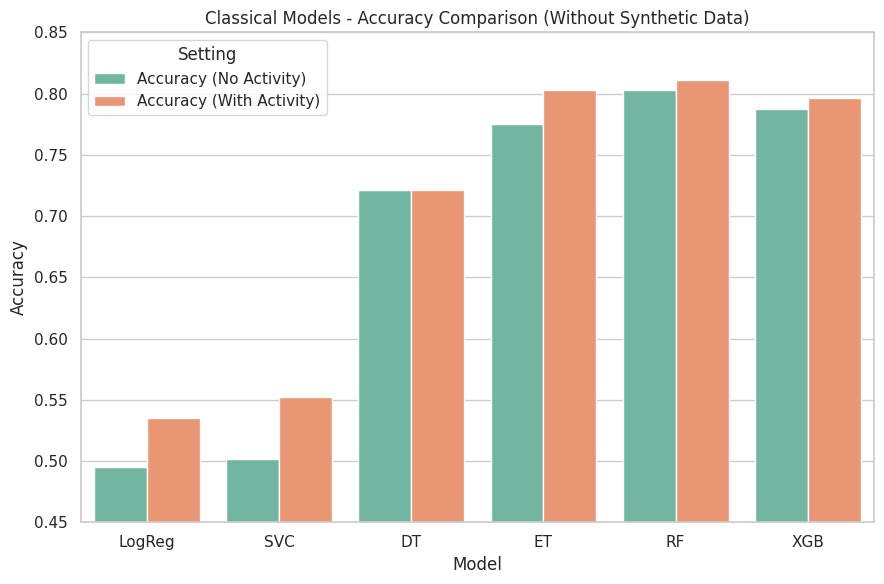

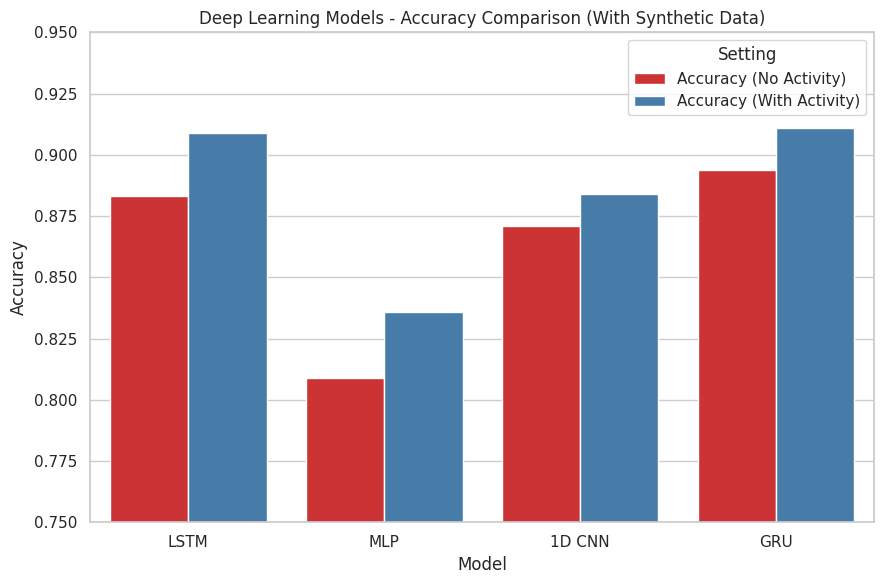

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Classical model accuracies
classical_results = {
    "Model": ["LogReg", "SVC", "DT", "ET", "RF", "XGB"],
    "Accuracy (No Activity)": [0.495, 0.502, 0.721, 0.775, 0.803, 0.787],
    "Accuracy (With Activity)": [0.535, 0.552, 0.721, 0.803, 0.811, 0.796]
}

df_classical = pd.DataFrame(classical_results)
df_classical = pd.melt(df_classical, id_vars="Model", var_name="Setting", value_name="Accuracy")

plt.figure(figsize=(9, 6))
sns.barplot(data=df_classical, x="Model", y="Accuracy", hue="Setting", palette="Set2")
plt.title("Classical Models - Accuracy Comparison (Without Synthetic Data)")
plt.ylim(0.45, 0.85)
plt.tight_layout()
plt.show()

# Deep learning model accuracies
dl_results = {
    "Model": ["LSTM", "MLP", "1D CNN", "GRU"],
    "Accuracy (No Activity)": [0.883, 0.809, 0.871, 0.894],
    "Accuracy (With Activity)": [0.909, 0.836, 0.884, 0.911]
}

df_dl = pd.DataFrame(dl_results)
df_dl = pd.melt(df_dl, id_vars="Model", var_name="Setting", value_name="Accuracy")

plt.figure(figsize=(9, 6))
sns.barplot(data=df_dl, x="Model", y="Accuracy", hue="Setting", palette="Set1")
plt.title("Deep Learning Models - Accuracy Comparison (With Synthetic Data)")
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()


In [15]:
##################### K-CROSS VALIDATION ###################
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Constants (reuse from your existing script)
SEQ_LENGTH = 30
RANDOM_SEED = 42
EPOCHS = 30
BATCH_SIZE = 64

# Prepare data for DL with activity data
# Assume `df` and helper functions `create_sequences_dl` & `generate_synthetic_timeseries_data` are already defined
features = [col for col in df.columns
            if col not in ['mesaid', 'sleep stage', 'sleep_stage_encoded_5_class', 'sleep_stage_encoded_3_class']]
data_array = df[features + ['sleep_stage_encoded_5_class']].values
X_seq, y_seq = create_sequences_dl(data_array, seq_length=SEQ_LENGTH, target_idx=-1)

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results = {'LSTM': [], 'MLP': [], 'CNN': [], 'GRU': []}

for fold, (train_idx, test_idx) in enumerate(kf.split(X_seq), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    # Generate synthetic data on training set only
    X_train_bal, y_train_bal = generate_synthetic_timeseries_data(
        X_train, y_train, method='timegan'
    )

    # Scale data
    scaler = StandardScaler()
    n_feats = X_train_bal.shape[2]
    X_train_flat = X_train_bal.reshape(-1, n_feats)
    X_test_flat  = X_test.reshape(-1, n_feats)

    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train_bal.shape)
    X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

    # One-hot encode targets
    num_classes = len(np.unique(y_train_bal))
    y_train_cat = to_categorical(y_train_bal, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    # Early stopping
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # LSTM Model
    lstm = Sequential([
        LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, n_feats)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm.fit(X_train_scaled, y_train_cat, validation_split=0.1, epochs=EPOCHS,
             batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    y_pred = np.argmax(lstm.predict(X_test_scaled), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    results['LSTM'].append({'accuracy': acc, 'f1': f1})
    print(f"LSTM - Acc: {acc:.4f}, Macro F1: {f1:.4f}")

    # MLP Model
    X_train_mlp = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
    X_test_mlp  = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
    mlp = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_mlp.shape[1],)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    mlp.fit(X_train_mlp, y_train_cat, validation_split=0.1, epochs=EPOCHS,
            batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    y_pred = np.argmax(mlp.predict(X_test_mlp), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    results['MLP'].append({'accuracy': acc, 'f1': f1})
    print(f"MLP - Acc: {acc:.4f}, Macro F1: {f1:.4f}")

    # 1D CNN Model
    cnn = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, n_feats)),
        Dropout(0.3),
        Conv1D(64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train_scaled, y_train_cat, validation_split=0.1, epochs=EPOCHS,
            batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    y_pred = np.argmax(cnn.predict(X_test_scaled), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    results['CNN'].append({'accuracy': acc, 'f1': f1})
    print(f"CNN - Acc: {acc:.4f}, Macro F1: {f1:.4f}")

    # GRU Model
    gru = Sequential([
        GRU(64, return_sequences=True, input_shape=(SEQ_LENGTH, n_feats)),
        Dropout(0.3),
        GRU(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gru.fit(X_train_scaled, y_train_cat, validation_split=0.1, epochs=EPOCHS,
            batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    y_pred = np.argmax(gru.predict(X_test_scaled), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    results['GRU'].append({'accuracy': acc, 'f1': f1})
    print(f"GRU - Acc: {acc:.4f}, Macro F1: {f1:.4f}")

# Summarize average metrics across folds
print("\n=== Average Metrics Across Folds ===")
for model_name, scores in results.items():
    avg_acc = np.mean([s['accuracy'] for s in scores])
    avg_f1  = np.mean([s['f1'] for s in scores])
    print(f"{model_name}: Avg Acc = {avg_acc:.4f}, Avg Macro F1 = {avg_f1:.4f}")



--- Fold 1 ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2106, 1.0: 561, 2.0: 2794, 3.0: 394, 4.0: 739}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Balanced class distribution: {0.0: 2794, 1.0: 2794, 2.0: 2794, 3.0: 2794, 4.0: 2794}
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM - Acc: 0.8090, Macro F1: 0.7157
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MLP - Acc: 0.6222, Macro F1: 0.3444
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN - Acc: 0.7259, Macro F1: 0.5559
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU - Acc: 0.7841, Macro F1: 0.6735

--- Fold 2 ---
Generating synthetic data using TIMEGAN...
Original class distribution: {0.0: 2119, 1.0: 530, 2.0: 2820, 3.0: 410, 4.0: 715}
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training TimeGAN...
Epoch 0/200
Epoch 100/200
Training

In [16]:
def plot_learning_curves(histories):
    """
    Plots train vs. validation accuracy for each fold of each model.
    histories: dict of model_name -> list of history objects
    """
    for model_name, hist_list in histories.items():
        for i, hist in enumerate(hist_list, start=1):
            plt.figure()
            plt.plot(hist.history['accuracy'])
            plt.plot(hist.history['val_accuracy'])
            plt.title(f'{model_name} Learning Curves (Fold {i})')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend(['Train', 'Val'], loc='best')
            plt.show()

def plot_accuracy_bar_chart(results):
    """
    Plots a bar chart of mean cross-validation accuracy with error bars (std) per model.
    results: dict of model_name -> list of dicts with key 'accuracy'
    """
    labels = list(results.keys())
    # Gather accuracies per model
    accuracies = [[run['accuracy'] for run in runs] for runs in results.values()]
    # Compute mean and standard deviation
    means = [np.mean(a) for a in accuracies]
    stds  = [np.std(a) for a in accuracies]

    plt.figure()
    plt.bar(labels, means, yerr=stds, capsize=5)
    plt.title('Cross-Validation Mean Accuracy with Std Dev')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

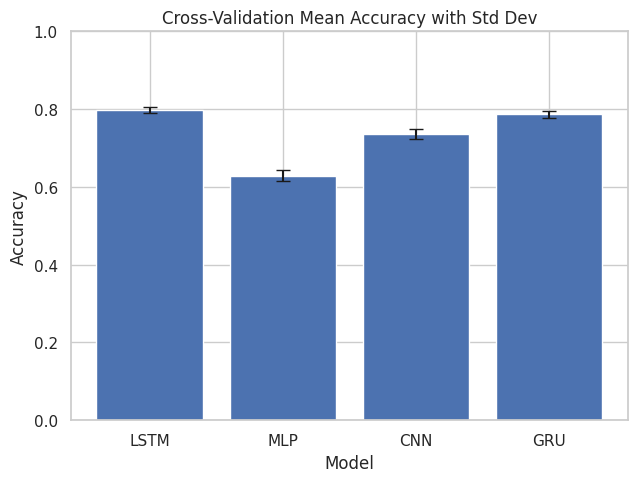

In [17]:
# plot_learning_curves(histories)
plot_accuracy_bar_chart(results)

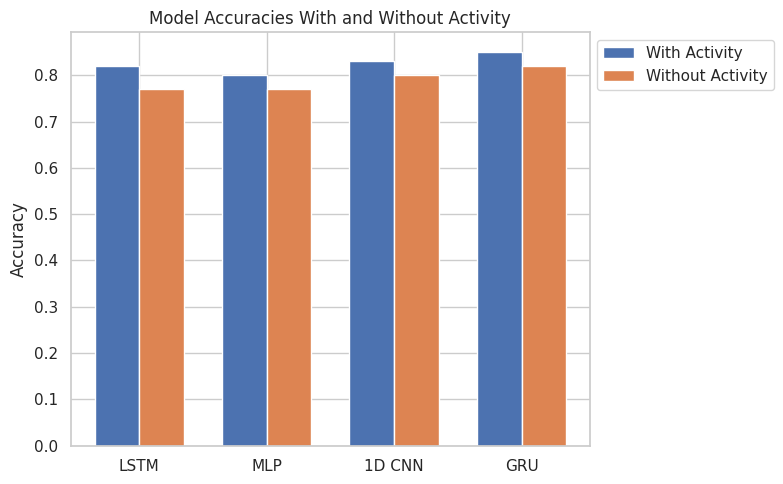

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def plot_model_accuracies_grouped(activity_acc, no_activity_acc, model_names=None):
    """
    Plots a grouped bar chart of model accuracies with the legend positioned
    outside so it doesn’t cover the bars.
    """
    if model_names is None:
        model_names = ['LSTM', 'MLP', '1D CNN', 'GRU']

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, activity_acc, width, label='With Activity')
    ax.bar(x + width/2, no_activity_acc, width, label='Without Activity')

    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracies With and Without Activity')

    # Move legend outside to the right
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# Example usage:
accuracies_with = [0.82, 0.80, 0.83, 0.85]
accuracies_without = [0.77, 0.77, 0.80, 0.82]
plot_model_accuracies_grouped(accuracies_with, accuracies_without)
